In [38]:
from itertools import product
import numpy as np
import pandas as pd
from ADRprofilePrediction import Pairs2Mat, evaluation, evaluation2
from APPFC import completion
from Models import loadHyperpar
import seaborn as sns 
import matplotlib.pylab as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.patheffects as path_effects
import json
import pingouin as pg
from functools import reduce

In [39]:
import sklearn
print(sklearn.__version__)

0.24.2


In [40]:
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NpEncoder, self).default(obj)

In [41]:
features_dict = {
    "target":Pairs2Mat(path="data/drug_target.tsv",colname1="0",colname2="1"),
    "enzyme":Pairs2Mat(path="data/drug_enzyme.tsv",colname1="0",colname2="1"),
    "Chem":pd.read_csv("data/drug_chemsfp.tsv",sep = "\t",header=0,index_col=0),
    "DGI":Pairs2Mat(path="data/interactions.tsv",colname1="drug_claim_name",colname2="gene_name"),
    "transporter":Pairs2Mat(path="data/drug_transporter.tsv",colname1="0",colname2="1"),
    "pathway":Pairs2Mat(path="data/drug_pathway.tsv",colname1="0",colname2="1"),
    "indication":Pairs2Mat(path="data/drug_indication.tsv",colname1="1_x",colname2="6")
}


In [42]:
filter = "all"
SEs = {}
if filter == "all":
    SIDER = Pairs2Mat(path="data/drug_se.tsv",colname1="1_x",colname2="5")
    column_sums = np.sum(SIDER, axis=0)
    SEs["SIDER"] = SIDER.loc[:, (column_sums >= 5)]

    OFFSIDES = Pairs2Mat(path="data/OFFSIDES.csv",colname1="drug_concept_name",colname2="condition_concept_name",sep = ",")
    column_sums = np.sum(OFFSIDES, axis=0)
    SEs["OFFSIDES"] = OFFSIDES.loc[:, column_sums >= 5]
elif filter == "rare":
    SIDER = Pairs2Mat(path="data/drug_se.tsv",colname1="1_x",colname2="5")
    column_sums = np.sum(SIDER, axis=0)
    SEs["SIDER"] = SIDER.loc[:, (column_sums < 50)]

    OFFSIDES = Pairs2Mat(path="data/OFFSIDES.csv",colname1="drug_concept_name",colname2="condition_concept_name",sep = ",")
    column_sums = np.sum(OFFSIDES, axis=0)
    SEs["OFFSIDES"] = OFFSIDES.loc[:, column_sums < 50]


In [43]:
SEs["SIDER"].shape

(1344, 2556)

In [44]:
SEs["OFFSIDES"].shape

(2730, 12750)

In [45]:

df_dict = features_dict
intersection_indices = df_dict['target'].index

for df_name, df in df_dict.items():
    intersection_indices = intersection_indices.intersection(df.index)
intersection_indices = intersection_indices.tolist()

print("Intersection indices:", intersection_indices)
print("Size of intersection set", len(intersection_indices))

Intersection indices: ['ACETAMINOPHEN', 'ACETAZOLAMIDE', 'ALFENTANIL', 'ALLOPURINOL', 'AMANTADINE', 'AMIODARONE', 'AMITRIPTYLINE', 'AMLODIPINE', 'AMOXICILLIN', 'AMPRENAVIR', 'ANASTROZOLE', 'APIXABAN', 'APOMORPHINE', 'ARIPIPRAZOLE', 'ATAZANAVIR', 'ATENOLOL', 'AZATHIOPRINE', 'AZELASTINE', 'AZITHROMYCIN', 'BENAZEPRIL', 'BENZOCAINE', 'BEPRIDIL', 'BETAMETHASONE', 'BEZAFIBRATE', 'BICALUTAMIDE', 'BISOPROLOL', 'BOSENTAN', 'BOSUTINIB', 'BROMOCRIPTINE', 'BUMETANIDE', 'BUPRENORPHINE', 'BUSPIRONE', 'CABERGOLINE', 'CANAGLIFLOZIN', 'CANDESARTAN', 'CARBAMAZEPINE', 'CARBOPLATIN', 'CARVEDILOL', 'CEFACLOR', 'CEFAZOLIN', 'CEFTRIAXONE', 'CELECOXIB', 'CERIVASTATIN', 'CHLORAMBUCIL', 'CHLORPROMAZINE', 'CHLORPROPAMIDE', 'CIDOFOVIR', 'CIMETIDINE', 'CINOXACIN', 'CIPROFLOXACIN', 'CISPLATIN', 'CITALOPRAM', 'CLADRIBINE', 'CLARITHROMYCIN', 'CLOBAZAM', 'CLOMIPRAMINE', 'CLONIDINE', 'CLOPIDOGREL', 'CLOTRIMAZOLE', 'CODEINE', 'COLCHICINE', 'CRIZOTINIB', 'CYPROHEPTADINE', 'DAPAGLIFLOZIN', 'DARUNAVIR', 'DASATINIB', 'DESIP

In [46]:
features_names = ["target", "enzyme", "Chem", "DGI", "transporter", "pathway", "indication"]
# SEs_names = ["SIDER", "OFFSIDES"]
# methods = ["SKR", "KR", "KRR", "Naive", "LNSM_RLN", "LNSM_jaccard", "VKR"]
methods = ["SKR", "KRR", "VKR", "Naive", "LNSM_RLN", "LNSM_jaccard"]
# methods = ["SKR", "KR", "KRR", "Naive", "LNSM_RLN", "LNSM_jaccard", "VKR", "SVM", "OCCA", "SCCA", "RF", "BRF"]
tuning_metrices=["AUROC", "AUPR", "AUROCperdrug", "AUPRperdrug"]
metrice_names = ["AUPR+AUROC", "AUPR+AUROCperdrug", "AUROC", "AUPR", "AUROCperdrug", "AUPRperdrug"]

In [56]:
A = 10**np.arange(-2, 3, 1, dtype=float)
B = np.arange(0.1, 1, 0.1, dtype=float)
C = np.arange(5, 205, 50, dtype=int)
C2 = np.arange(5, 20, 5, dtype=int)
A10 = 10**np.arange(1, 2, 1, dtype=float)
A100 = 10**np.arange(2, 3, 1, dtype=float)
all_hyperparlist = {
    "SKR":[A,B,A10,A100], 
    "KRR":[A,A],
    "VKR":[A,A,C2], 
    # "Naive":[], 
    # "LNSM_RLN":[B,A], 
    # "LNSM_jaccard":[B], 
    # "SVM":[A,A,A], 
    # "OCCA":[], 
    # "SCCA":[A], 
    # "RF":[C], 
    # "BRF":[C],
    "TNMF":[C],
    "TWNMF":[C]
}

In [48]:
SEs_name = "OFFSIDES"
metrice = "mse"

In [35]:
fhyperpars = {}
fhyperpars["nested_cv"] = {}
fhyperpars["cv"] = {}
fhyperparsOut = {}
fhyperparsOut["nested_cv"] = {}
fhyperparsOut["cv"] = {}
fresults = {}
fresults["nested_cv"] = {}
fresults["cv"] = {}

In [36]:

# Open and read the JSON file
# with open(f'results/hyperpars_{SEs_name}.xml', 'r') as xml_file:

#     hyperpars = json.load(xml_file)

In [ ]:
method = "TNMF"
validation = "nested_cv"
fhyperparsOut[validation][method] = {}
fresults[validation][method] = {}
hyperparList = loadHyperpar(*all_hyperparlist[method],method_option=method)
fresults[validation][method], fhyperparsOut[validation][method], features_new = completion(Y=SEs[SEs_name], X=features_dict, method_option=method,tuning_metrice=metrice,hyperparList=hyperparList,Validation=validation,n_jobs=3)

validation = "cv"
fhyperparsOut[validation][method] = {}
fresults[validation][method] = {}
hyperparList = loadHyperpar(*all_hyperparlist[method],method_option=method)
fresults[validation], fhyperparsOut[validation][method], features_new = completion(Y=SEs[SEs_name], X=features_dict, method_option=method,tuning_metrice=metrice,hyperparList=hyperparList,Validation=validation,n_jobs=1)

In [15]:
fhyperparsOut

{'nested_cv': {'TNMF': [(105,), (105,), (105,), (105,), (155,)]},
 'cv': {'TNMF': (105,)}}

In [16]:
with open(f'results/fhyperpars_{SEs_name}.xml', 'w') as xml_file:
   json.dump(fhyperparsOut, xml_file, cls=NpEncoder)
with open(f'results/fresults_{SEs_name}_{method}.xml', 'w') as xml_file:
   json.dump(fresults, xml_file)

In [17]:
# method = "KRR"
# validation = "nested_cv"
# hyperparsOut[validation][method] = {}
# results[validation][method] = {}
# str = "DGI"
# hyperparList = loadHyperpar(*all_hyperparlist[method],method_option=method)
# results[validation][method]["noAPPFC"][str], hyperparsOut[validation][method][str]["noAPPFC"] = evaluation(Y=SEs["SIDER"], X=features_dict[str], method_option=method,tuning_metrice=metrice, hyperparList=hyperparList,Validation=validation,n_jobs=1)

In [49]:
method = "TNMF"
validation = "completion"
hyperparList = loadHyperpar(*all_hyperparlist[method],method_option=method)
features_new = completion(Y=SEs[SEs_name], X=features_dict,method_option=method,tuning_metrice=metrice,hyperparList=hyperparList,hyperparfixed=(105,),Validation=validation,n_jobs=1)

The TNMF requires hyperparameter k
common drugs chosen to be the test set:  set()
TNMF starts:
TNMF ends:


In [54]:
with open(f'results/hyperpars_{SEs_name}.xml', 'r') as xml_file:
    hyperparsOut = json.load(xml_file)
with open(f'results/results_{SEs_name}.xml', 'r') as xml_file:
    results = json.load(xml_file)

In [57]:
hyperpars = {}
hyperpars["nested_cv"] = {}
hyperpars["cv"] = {}
# hyperparsOut = {}
# hyperparsOut["nested_cv"] = {}
# hyperparsOut["cv"] = {}
# results = {}
# results["nested_cv"] = {}
# results["cv"] = {}

In [58]:
method = "KRR"
metrice = "AUPR"
validation = "nested_cv"
hyperparsOut[validation][method] = {}
results[validation][method] = {}
hyperparsOut[validation][method]["noAPPFC"] = {}
results[validation][method]["noAPPFC"] = {}
hyperparsOut[validation][method]["APPFC"] = {}
results[validation][method]["APPFC"] = {}
for str in features_names:
    print(f"using feature {str}")
    print("without APPFC")
    hyperparList = loadHyperpar(*all_hyperparlist[method],method_option=method)
    results[validation][method]["noAPPFC"][str], hyperparsOut[validation][method]["noAPPFC"][str] = evaluation(Y=SEs[SEs_name], X=features_dict[str], method_option=method,tuning_metrice=metrice,hyperparList=hyperparList,Validation=validation,n_jobs=1)
    print("with APPFC")
    hyperparList = loadHyperpar(*all_hyperparlist[method],method_option=method)
    results[validation][method]["APPFC"][str], hyperparsOut[validation][method]["APPFC"][str] = evaluation2(Y=SEs[SEs_name], X=features_dict[str], X2=features_new[str], method_option=method,tuning_metrice=metrice,hyperparList=hyperparList,Validation=validation,n_jobs=10)

using feature target
without APPFC
The KRR requires hyperparameter lambda, sigma_X
---------- nested cv start ----------
Fold: 0
number of hyperpars combination:  25
first few training idx:  [ 7 10 12 13 14 15 16 17 18 20]
first few testing idx:  [ 656  799  872 1389 1502 1727 1757 2448 2640 2698]
Inner Fold: 0
Inner Fold: 1
Inner Fold: 2
Inner Fold: 3
best hyperpar: (1.0, 10.0)
AUPR: 0.47876699545631696
AUPR for each fold: [0.45792429 0.50579213 0.48692122 0.46443035]
--- tuning end ---
target size: 226
------ best hyper pars:  (1.0, 10.0) ------
KRR starts:
KRR ends:
-----------
AUPRperdrug: 0.6049743854845498
AUROCperdrug: 0.9460628808361066
AUPR+AUROCperdrug: 1.5510372663206564
AUPR: 0.456292134901036
AUROC: 0.8381684900232508
AUPR+AUROC: 1.2944606249242867
-----------
Fold: 1
number of hyperpars combination:  25
first few training idx:  [ 7 12 14 15 16 17 18 19 20 22]
first few testing idx:  [ 124  172  541  635 1270 1421 1433 1957 2517 2538]
Inner Fold: 0
Inner Fold: 1
Inner Fold

In [59]:
method = "KRR"
validation = "cv"
hyperparsOut[validation][method] = {}
results[validation][method] = {}
hyperparsOut[validation][method]["noAPPFC"] = {}
results[validation][method]["noAPPFC"] = {}
hyperparsOut[validation][method]["APPFC"] = {}
results[validation][method]["APPFC"] = {}
for str in features_names:
    print(f"using feature {str}")
    print("without APPFC")
    hyperparList = loadHyperpar(*all_hyperparlist[method],method_option=method)
    results[validation][method]["noAPPFC"][str], hyperparsOut[validation][method]["noAPPFC"][str] = evaluation(Y=SEs[SEs_name], X=features_dict[str], method_option=method,tuning_metrice=metrice,hyperparList=hyperparList,Validation=validation,n_jobs=1)
    print("with APPFC")
    hyperparList = loadHyperpar(*all_hyperparlist[method],method_option=method)
    results[validation][method]["APPFC"][str], hyperparsOut[validation][method]["APPFC"][str] = evaluation2(Y=SEs[SEs_name], X=features_dict[str], X2=features_new[str], method_option=method,tuning_metrice=metrice,hyperparList=hyperparList,Validation=validation,n_jobs=10)

using feature target
without APPFC
The KRR requires hyperparameter lambda, sigma_X
---------- cv start ----------
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
best hyperpar: (1.0, 10.0)
AUPR: 0.4749089731750519
AUPR for each fold: [0.45629213 0.49374813 0.4644927  0.47765438 0.48235752]
--- tuning end ---
target size: 374
------ best hyper pars:  (1.0, 10.0) ------
KRR starts:
KRR ends:
-----------
AUPRperdrug: 0.6269242400206464
AUROCperdrug: 0.9480541366041201
AUPR+AUROCperdrug: 1.5749783766247665
AUPR: 0.4790384280282022
AUROC: 0.8433709140461756
AUPR+AUROC: 1.3224093420743777
-----------
with APPFC
The KRR requires hyperparameter lambda, sigma_X
---------- cv start ----------
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
best hyperpar: (0.01, 10.0)
AUPR: 0.5780610707901699
AUPR for each fold: [0.57158505 0.56709616 0.58696065 0.57106781 0.59359568]
--- tuning end ---
target size: 374
------ best hyper pars:  (0.01, 10.0) ------
KRR starts:
KRR ends:
-----------
AUPRperdrug: 0.6230003608435731

In [94]:
method = "KRR"
df = pd.DataFrame()
for m, fs in results["nested_cv"]["KRR"].items():
    for f, mes in fs.items():
        for me, scores in mes.items():
            temp_df = pd.DataFrame({
                'method': m,
                'feature': f,
                'metric': me,
                "score": scores
            })
            df = pd.concat([df, temp_df], ignore_index=True)

custom_order = ["pathway","Chem", "DGI", "indication", "target", "transporter", "enzyme"]
# metrice_names = ["AUROC", "AUPR", "AUROCperdrug", "AUPRperdrug"]
metrice_names = ["AUPR+AUROC", "AUPR+AUROCperdrug", "AUROC", "AUPR", "AUROCperdrug", "AUPRperdrug"]
APPFC = ["APPFC", "noAPPFC"]
df['feature'] = pd.Categorical(df['feature'], categories=custom_order, ordered=True)
df['method'] = pd.Categorical(df['method'], categories=APPFC, ordered=True)
df['metric'] = pd.Categorical(df['metric'], categories=metrice_names, ordered=True)
df2 = pd.pivot_table(df, values=['score'], index=["feature", "method"], aggfunc={'score': ["mean","std"]}, columns=["metric"])
df3 = df2.sort_index(axis=1, level='metric').sort_index(level='feature')
df3.to_excel(f'results/nested_cv_results_{SEs_name}_{method}.xlsx')
df3

score                                                 \
                          mean        std              mean               std   
metric              AUPR+AUROC AUPR+AUROC AUPR+AUROCperdrug AUPR+AUROCperdrug   
feature     method                                                              
pathway     APPFC     1.506208   0.017510          1.598697          0.009113   
            noAPPFC   1.392904   0.030547          1.595578          0.020617   
Chem        APPFC     1.415830   0.026196          1.605724          0.046731   
            noAPPFC   1.421649   0.037574          1.642262          0.012324   
DGI         APPFC     1.473365   0.022305          1.547185          0.015892   
            noAPPFC   1.444430   0.032197          1.533964          0.021067   
indication  APPFC     1.552219   0.035199          1.635339          0.017761   
            noAPPFC   1.535037   0.024133          1.622366          0.010848   
target      APPFC     1.454796   0.015904          1.565036          0.014662   
            noAPPFC   1.319941   0.026163          1.567990          0.011947   
transporter APPFC     1.449791   0.023790          1.603142          0.030162   
            noAPPFC   1.417157   0.019149          1.628165          0.011188   
enzyme      APPFC     1.474936   0.031222          1.592908          0.010817   
            noAPPFC   1.385651   0.025197          1.585035          0.017861   

                                                                          \
                         mean       std      mean       std         mean   
metric                  AUROC     AUROC      AUPR      AUPR AUROCperdrug   
feature     method                                                         
pathway     APPFC    0.882595  0.003589  0.623612  0.015322     0.946403   
            noAPPFC  0.855348  0.013630  0.537556  0.021549     0.945966   
Chem        APPFC    0.848045  0.008317  0.567785  0.020782     0.928875   
            noAPPFC  0.854061  0.013732  0.567588  0.024040     0.940845   
DGI         APPFC    0.878929  0.008001  0.594435  0.023662     0.945094   
            noAPPFC  0.876455  0.007078  0.567975  0.029341     0.942156   
indication  APPFC    0.891308  0.007431  0.660911  0.029870     0.942187   
            noAPPFC  0.882436  0.009587  0.652601  0.016985     0.936975   
target      APPFC    0.876735  0.007099  0.578061  0.011528     0.946275   
            noAPPFC  0.847404  0.016206  0.472537  0.014220     0.947710   
transporter APPFC    0.845974  0.022840  0.603817  0.020633     0.928001   
            noAPPFC  0.846645  0.008422  0.570512  0.014290     0.938727   
enzyme      APPFC    0.875740  0.012219  0.599196  0.022291     0.944325   
            noAPPFC  0.854764  0.017829  0.530887  0.013735     0.942723   

                                                          
                             std        mean         std  
metric              AUROCperdrug AUPRperdrug AUPRperdrug  
feature     method                                        
pathway     APPFC       0.001007    0.652294    0.008895  
            noAPPFC     0.005271    0.649612    0.016181  
Chem        APPFC       0.015852    0.676849    0.031781  
            noAPPFC     0.001332    0.701417    0.012112  
DGI         APPFC       0.005746    0.602091    0.019298  
            noAPPFC     0.004456    0.591807    0.024884  
indication  APPFC       0.001915    0.693153    0.019544  
            noAPPFC     0.002105    0.685391    0.011208  
target      APPFC       0.002748    0.618762    0.017312  
            noAPPFC     0.002999    0.620280    0.013026  
transporter APPFC       0.018560    0.675140    0.012960  
            noAPPFC     0.001972    0.689438    0.011274  
enzyme      APPFC       0.001003    0.648584    0.010642  
            noAPPFC     0.002818    0.642312    0.019760

In [95]:
df = pd.DataFrame()
for m, fs in results["cv"]["KRR"].items():
    for f, mes in fs.items():
        for me, scores in mes.items():
            temp_df = pd.DataFrame({
                'method': m,
                'feature': f,
                'metric': me,
                "score": scores
            },index=["1"])
            df = pd.concat([df, temp_df], ignore_index=True)
df['feature'] = pd.Categorical(df['feature'], categories=custom_order, ordered=True)
df['method'] = pd.Categorical(df['method'], categories=APPFC, ordered=True)
df['metric'] = pd.Categorical(df['metric'], categories=metrice_names, ordered=True)
df2 = pd.pivot_table(df, values=['score'], index=["feature", "method"], columns="metric")
df2.to_excel(f'results/cv_results_{SEs_name}_{method}.xlsx')
df2

score                                        \
metric              AUPR+AUROC AUPR+AUROCperdrug     AUROC      AUPR   
feature     method                                                     
pathway     APPFC     1.489545          1.592093  0.874163  0.615382   
            noAPPFC   1.361145          1.595685  0.846439  0.514706   
Chem        APPFC     1.406462          1.555082  0.836128  0.570334   
            noAPPFC   1.388035          1.630454  0.846088  0.541946   
DGI         APPFC     1.469463          1.552685  0.882249  0.587214   
            noAPPFC   1.471755          1.532903  0.885908  0.585847   
indication  APPFC     1.549120          1.640102  0.887290  0.661830   
            noAPPFC   1.557342          1.620619  0.890684  0.666658   
target      APPFC     1.430229          1.567935  0.865179  0.565050   
            noAPPFC   1.322409          1.574978  0.843371  0.479038   
transporter APPFC     1.427356          1.589231  0.835465  0.591891   
            noAPPFC   1.430646          1.628635  0.846328  0.584318   
enzyme      APPFC     1.473552          1.605870  0.876744  0.596808   
            noAPPFC   1.388446          1.598141  0.853094  0.535352   

                                              
metric              AUROCperdrug AUPRperdrug  
feature     method                            
pathway     APPFC       0.946226    0.645867  
            noAPPFC     0.948456    0.647229  
Chem        APPFC       0.916269    0.638812  
            noAPPFC     0.942573    0.687881  
DGI         APPFC       0.947686    0.604999  
            noAPPFC     0.942284    0.590619  
indication  APPFC       0.945973    0.694129  
            noAPPFC     0.938958    0.681661  
target      APPFC       0.944935    0.623000  
            noAPPFC     0.948054    0.626924  
transporter APPFC       0.920659    0.668572  
            noAPPFC     0.933561    0.695074  
enzyme      APPFC       0.943850    0.662021  
            noAPPFC     0.942228    0.655913

In [60]:
method = "SKR"
metrice = "AUPR"
validation = "nested_cv"
hyperparsOut[validation][method] = {}
results[validation][method] = {}
hyperparsOut[validation][method]["noAPPFC"] = {}
results[validation][method]["noAPPFC"] = {}
hyperparsOut[validation][method]["APPFC"] = {}
results[validation][method]["APPFC"] = {}
for str in features_names:
    print(f"using feature {str}")
    print("without APPFC")
    hyperparList = loadHyperpar(*all_hyperparlist[method],method_option=method)
    results[validation][method]["noAPPFC"][str], hyperparsOut[validation][method]["noAPPFC"][str] = evaluation(Y=SEs[SEs_name], X=features_dict[str], method_option=method,tuning_metrice=metrice,hyperparList=hyperparList,Validation=validation,n_jobs=1)
    print("with APPFC")
    hyperparList = loadHyperpar(*all_hyperparlist[method],method_option=method)
    results[validation][method]["APPFC"][str], hyperparsOut[validation][method]["APPFC"][str] = evaluation2(Y=SEs[SEs_name], X=features_dict[str], X2=features_new[str], method_option=method,tuning_metrice=metrice,hyperparList=hyperparList,Validation=validation,n_jobs=10)

using feature target
without APPFC
The SKR requires hyperparameter lambda, c, sigma_X, sigma_Y
---------- nested cv start ----------
Fold: 0
number of hyperpars combination:  45
first few training idx:  [ 7 10 12 13 14 15 16 17 18 20]
first few testing idx:  [ 656  799  872 1389 1502 1727 1757 2448 2640 2698]
Inner Fold: 0
Inner Fold: 1
Inner Fold: 2
Inner Fold: 3
best hyperpar: (0.01, 0.7000000000000001, 10.0, 100.0)
AUPR: 0.480036088683164
AUPR for each fold: [0.46155085 0.49877516 0.49126915 0.46854919]
--- tuning end ---
target size: 226
------ best hyper pars:  (0.01, 0.7000000000000001, 10.0, 100.0) ------
SKR starts:
SKR ends:
-----------
AUPRperdrug: 0.6063082540704298
AUROCperdrug: 0.9467278356403708
AUPR+AUROCperdrug: 1.5530360897108006
AUPR: 0.46843390266227447
AUROC: 0.8426138784123827
AUPR+AUROC: 1.3110477810746572
-----------
Fold: 1
number of hyperpars combination:  45
first few training idx:  [ 7 12 14 15 16 17 18 19 20 22]
first few testing idx:  [ 124  172  541  635 1

In [61]:
method = "SKR"
validation = "cv"
hyperparsOut[validation][method] = {}
results[validation][method] = {}
hyperparsOut[validation][method]["noAPPFC"] = {}
results[validation][method]["noAPPFC"] = {}
hyperparsOut[validation][method]["APPFC"] = {}
results[validation][method]["APPFC"] = {}
for str in features_names:
    print(f"using feature {str}")
    print("without APPFC")
    hyperparList = loadHyperpar(*all_hyperparlist[method],method_option=method)
    results[validation][method]["noAPPFC"][str], hyperparsOut[validation][method]["noAPPFC"][str] = evaluation(Y=SEs[SEs_name], X=features_dict[str], method_option=method,tuning_metrice=metrice,hyperparList=hyperparList,Validation=validation,n_jobs=1)
    print("with APPFC")
    hyperparList = loadHyperpar(*all_hyperparlist[method],method_option=method)
    results[validation][method]["APPFC"][str], hyperparsOut[validation][method]["APPFC"][str] = evaluation2(Y=SEs[SEs_name], X=features_dict[str], X2=features_new[str], method_option=method,tuning_metrice=metrice,hyperparList=hyperparList,Validation=validation,n_jobs=10)

using feature target
without APPFC
The SKR requires hyperparameter lambda, c, sigma_X, sigma_Y
---------- cv start ----------
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
best hyperpar: (0.01, 0.6, 10.0, 100.0)
AUPR: 0.4827965045909691
AUPR for each fold: [0.4702759  0.50472349 0.46598871 0.48915206 0.48384237]
--- tuning end ---
target size: 374
------ best hyper pars:  (0.01, 0.6, 10.0, 100.0) ------
SKR starts:
SKR ends:
-----------
AUPRperdrug: 0.6275461842943979
AUROCperdrug: 0.9480141664543575
AUPR+AUROCperdrug: 1.5755603507487554
AUPR: 0.49300482661159245
AUROC: 0.850522751693893
AUPR+AUROC: 1.3435275783054854
-----------
with APPFC
The SKR requires hyperparameter lambda, c, sigma_X, sigma_Y
---------- cv start ----------
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
best hyperpar: (0.01, 0.1, 10.0, 100.0)
AUPR: 0.5785192076212101
AUPR for each fold: [0.574029   0.56763988 0.58595121 0.57010038 0.59487557]
--- tuning end ---
target size: 374
------ best hyper pars:  (0.01, 0.1, 10.0, 100.0

In [96]:
method = "SKR"
df = pd.DataFrame()
for m, fs in results["nested_cv"]["SKR"].items():
    for f, mes in fs.items():
        for me, scores in mes.items():
            temp_df = pd.DataFrame({
                'method': m,
                'feature': f,
                'metric': me,
                "score": scores
            })
            df = pd.concat([df, temp_df], ignore_index=True)

custom_order = ["pathway","Chem", "DGI",  "indication", "target", "transporter", "enzyme"]
# metrice_names = ["AUROC", "AUPR", "AUROCperdrug", "AUPRperdrug"]
metrice_names = ["AUPR+AUROC", "AUPR+AUROCperdrug", "AUROC", "AUPR", "AUROCperdrug", "AUPRperdrug"]
APPFC = ["APPFC", "noAPPFC"]
df['feature'] = pd.Categorical(df['feature'], categories=custom_order, ordered=True)
df['method'] = pd.Categorical(df['method'], categories=APPFC, ordered=True)
df['metric'] = pd.Categorical(df['metric'], categories=metrice_names, ordered=True)
df2 = pd.pivot_table(df, values=['score'], index=["feature", "method"], aggfunc={'score': ["mean","std"]}, columns=["metric"])
df3 = df2.sort_index(axis=1, level='metric').sort_index(level='feature')
df3.to_excel(f'results/nested_cv_results_{SEs_name}_{method}.xlsx')
df3

score                                                 \
                          mean        std              mean               std   
metric              AUPR+AUROC AUPR+AUROC AUPR+AUROCperdrug AUPR+AUROCperdrug   
feature     method                                                              
pathway     APPFC     1.506594   0.017115          1.599978          0.009056   
            noAPPFC   1.401497   0.021288          1.598323          0.009851   
Chem        APPFC     1.476231   0.025890          1.633261          0.011301   
            noAPPFC   1.426274   0.035336          1.641123          0.012506   
DGI         APPFC     1.478420   0.023343          1.550023          0.016598   
            noAPPFC   1.445483   0.031700          1.540142          0.021331   
indication  APPFC     1.557025   0.033502          1.637753          0.017319   
            noAPPFC   1.537678   0.022922          1.629254          0.010828   
target      APPFC     1.455301   0.014605          1.568383          0.015090   
            noAPPFC   1.330099   0.027316          1.567423          0.012819   
transporter APPFC     1.469375   0.023424          1.636262          0.014640   
            noAPPFC   1.425233   0.011769          1.625982          0.012356   
enzyme      APPFC     1.474968   0.031298          1.594316          0.011055   
            noAPPFC   1.386749   0.023637          1.586822          0.018072   

                                                                          \
                         mean       std      mean       std         mean   
metric                  AUROC     AUROC      AUPR      AUPR AUROCperdrug   
feature     method                                                         
pathway     APPFC    0.882981  0.003738  0.623613  0.015046     0.946802   
            noAPPFC  0.859546  0.009105  0.541951  0.015737     0.947296   
Chem        APPFC    0.867099  0.008314  0.609133  0.017812     0.936676   
            noAPPFC  0.855048  0.012779  0.571227  0.022928     0.940554   
DGI         APPFC    0.879941  0.005565  0.598479  0.024371     0.946016   
            noAPPFC  0.878000  0.006310  0.567483  0.029418     0.944204   
indication  APPFC    0.891686  0.007337  0.665340  0.029199     0.942839   
            noAPPFC  0.884576  0.008846  0.653102  0.016667     0.939594   
target      APPFC    0.877925  0.005266  0.577377  0.011847     0.947381   
            noAPPFC  0.848763  0.015855  0.481336  0.015001     0.947853   
transporter APPFC    0.859327  0.005215  0.610048  0.022192     0.940124   
            noAPPFC  0.848771  0.005271  0.576462  0.011610     0.938305   
enzyme      APPFC    0.875903  0.012035  0.599065  0.022254     0.944706   
            noAPPFC  0.855346  0.017263  0.531402  0.013225     0.943182   

                                                          
                             std        mean         std  
metric              AUROCperdrug AUPRperdrug AUPRperdrug  
feature     method                                        
pathway     APPFC       0.000958    0.653176    0.008884  
            noAPPFC     0.001394    0.651027    0.009619  
Chem        APPFC       0.000972    0.696585    0.011044  
            noAPPFC     0.001318    0.700569    0.012442  
DGI         APPFC       0.003994    0.604007    0.020313  
            noAPPFC     0.004096    0.595939    0.024959  
indication  APPFC       0.002308    0.694914    0.019215  
            noAPPFC     0.001838    0.689660    0.011374  
target      APPFC       0.002632    0.621002    0.017662  
            noAPPFC     0.002354    0.619570    0.013970  
transporter APPFC       0.003343    0.696138    0.017112  
            noAPPFC     0.002374    0.687677    0.011957  
enzyme      APPFC       0.000913    0.649609    0.010828  
            noAPPFC     0.002758    0.643639    0.019868

In [97]:
df = pd.DataFrame()
for m, fs in results["cv"]["SKR"].items():
    for f, mes in fs.items():
        for me, scores in mes.items():
            temp_df = pd.DataFrame({
                'method': m,
                'feature': f,
                'metric': me,
                "score": scores
            },index=["1"])
            df = pd.concat([df, temp_df], ignore_index=True)
df['feature'] = pd.Categorical(df['feature'], categories=custom_order, ordered=True)
df['method'] = pd.Categorical(df['method'], categories=APPFC, ordered=True)
df['metric'] = pd.Categorical(df['metric'], categories=metrice_names, ordered=True)
df2 = pd.pivot_table(df, values=['score'], index=["feature", "method"], columns="metric")
df2.to_excel(f'results/cv_results_{SEs_name}_{method}.xlsx')
df2

score                                        \
metric              AUPR+AUROC AUPR+AUROCperdrug     AUROC      AUPR   
feature     method                                                     
pathway     APPFC     1.488412          1.593646  0.874410  0.614002   
            noAPPFC   1.366555          1.592474  0.847834  0.518721   
Chem        APPFC     1.442067          1.616839  0.855982  0.586086   
            noAPPFC   1.391053          1.629296  0.847235  0.543818   
DGI         APPFC     1.464299          1.550154  0.876992  0.587307   
            noAPPFC   1.471534          1.539368  0.887038  0.584497   
indication  APPFC     1.540102          1.638174  0.883923  0.656180   
            noAPPFC   1.557610          1.627590  0.891850  0.665760   
target      APPFC     1.432505          1.570728  0.866620  0.565884   
            noAPPFC   1.343528          1.575560  0.850523  0.493005   
transporter APPFC     1.487926          1.658625  0.865603  0.622323   
            noAPPFC   1.429047          1.633115  0.845315  0.583732   
enzyme      APPFC     1.474596          1.607425  0.876907  0.597689   
            noAPPFC   1.391059          1.600003  0.853568  0.537491   

                                              
metric              AUROCperdrug AUPRperdrug  
feature     method                            
pathway     APPFC       0.946693    0.646953  
            noAPPFC     0.947897    0.644577  
Chem        APPFC       0.936277    0.680562  
            noAPPFC     0.942282    0.687014  
DGI         APPFC       0.946082    0.604072  
            noAPPFC     0.944409    0.594959  
indication  APPFC       0.944804    0.693370  
            noAPPFC     0.941462    0.686128  
target      APPFC       0.945902    0.624825  
            noAPPFC     0.948014    0.627546  
transporter APPFC       0.941616    0.717009  
            noAPPFC     0.934535    0.698580  
enzyme      APPFC       0.944291    0.663134  
            noAPPFC     0.942642    0.657361

In [18]:
method = "VKR"
metrice = "AUPR"
validation = "nested_cv"
hyperparsOut[validation][method] = {}
results[validation][method] = {}
hyperparsOut[validation][method]["noAPPFC"] = {}
results[validation][method]["noAPPFC"] = {}
hyperparsOut[validation][method]["APPFC"] = {}
results[validation][method]["APPFC"] = {}
for str in features_names:
    print(f"using feature {str}")
    print("without APPFC")
    hyperparList = loadHyperpar(*all_hyperparlist[method],method_option=method)
    results[validation][method]["noAPPFC"][str], hyperparsOut[validation][method]["noAPPFC"][str] = evaluation(Y=SEs[SEs_name], X=features_dict[str], method_option=method,tuning_metrice=metrice,hyperparList=hyperparList,Validation=validation,n_jobs=1)
    print("with APPFC")
    hyperparList = loadHyperpar(*all_hyperparlist[method],method_option=method)
    results[validation][method]["APPFC"][str], hyperparsOut[validation][method]["APPFC"][str] = evaluation2(Y=SEs[SEs_name], X=features_dict[str], X2=features_new[str], method_option=method,tuning_metrice=metrice,hyperparList=hyperparList,Validation=validation,n_jobs=10)

using feature target
without APPFC
The VKR requires hyperparameter lambda, sigma_X, k
---------- nested cv start ----------
Fold: 0
number of hyperpars combination:  75
first few training idx:  [ 7 10 12 13 14 15 16 17 18 20]
first few testing idx:  [ 656  799  872 1389 1502 1727 1757 2448 2640 2698]
Inner Fold: 0
Inner Fold: 1
Inner Fold: 2
Inner Fold: 3
best hyperpar: (10.0, 0.1, 15)
AUPR: 0.47867475129620163
AUPR for each fold: [0.45686832 0.50550336 0.48219674 0.47013059]
--- tuning end ---
target size: 226
------ best hyper pars:  (10.0, 0.1, 15) ------
VKR starts:
VKR ends:
-----------
AUPRperdrug: 0.6078040251652234
AUROCperdrug: 0.947284456208504
AUPR+AUROCperdrug: 1.5550884813737273
AUPR: 0.458911170787034
AUROC: 0.841203801420788
AUPR+AUROC: 1.300114972207822
-----------
Fold: 1
number of hyperpars combination:  75
first few training idx:  [ 7 12 14 15 16 17 18 19 20 22]
first few testing idx:  [ 124  172  541  635 1270 1421 1433 1957 2517 2538]
Inner Fold: 0
Inner Fold: 1
In

In [19]:
method = "VKR"
validation = "cv"
hyperparsOut[validation][method] = {}
results[validation][method] = {}
hyperparsOut[validation][method]["noAPPFC"] = {}
results[validation][method]["noAPPFC"] = {}
hyperparsOut[validation][method]["APPFC"] = {}
results[validation][method]["APPFC"] = {}
for str in features_names:
    print(f"using feature {str}")
    print("without APPFC")
    hyperparList = loadHyperpar(*all_hyperparlist[method],method_option=method)
    results[validation][method]["noAPPFC"][str], hyperparsOut[validation][method]["noAPPFC"][str] = evaluation(Y=SEs[SEs_name], X=features_dict[str], method_option=method,tuning_metrice=metrice,hyperparList=hyperparList,Validation=validation,n_jobs=1)
    print("with APPFC")
    hyperparList = loadHyperpar(*all_hyperparlist[method],method_option=method)
    results[validation][method]["APPFC"][str], hyperparsOut[validation][method]["APPFC"][str] = evaluation2(Y=SEs[SEs_name], X=features_dict[str], X2=features_new[str], method_option=method,tuning_metrice=metrice,hyperparList=hyperparList,Validation=validation,n_jobs=10)

using feature target
without APPFC
The VKR requires hyperparameter lambda, sigma_X, k
---------- cv start ----------
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
best hyperpar: (10.0, 0.01, 15)
AUPR: 0.48126096227470283
AUPR for each fold: [0.47821734 0.51384328 0.4685461  0.48137373 0.46432436]
--- tuning end ---
target size: 374
------ best hyper pars:  (10.0, 0.01, 15) ------
VKR starts:
VKR ends:
-----------
AUPRperdrug: 0.6271049306741578
AUROCperdrug: 0.9488990879696244
AUPR+AUROCperdrug: 1.5760040186437823
AUPR: 0.49836223122326273
AUROC: 0.85460566932511
AUPR+AUROC: 1.3529679005483728
-----------
with APPFC
The VKR requires hyperparameter lambda, sigma_X, k
---------- cv start ----------
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
best hyperpar: (10.0, 0.01, 15)
AUPR: 0.5874761860824048
AUPR for each fold: [0.58450591 0.57342546 0.59575246 0.58263586 0.60106125]
--- tuning end ---
target size: 374
------ best hyper pars:  (10.0, 0.01, 15) ------
VKR starts:
VKR ends:
-----------
AUPRper

In [98]:
method = "VKR"
df = pd.DataFrame()
for m, fs in results["nested_cv"]["VKR"].items():
    for f, mes in fs.items():
        for me, scores in mes.items():
            temp_df = pd.DataFrame({
                'method': m,
                'feature': f,
                'metric': me,
                "score": scores
            })
            df = pd.concat([df, temp_df], ignore_index=True)

custom_order = ["pathway","Chem", "DGI",  "indication", "target", "transporter", "enzyme"]
# metrice_names = ["AUROC", "AUPR", "AUROCperdrug", "AUPRperdrug"]
metrice_names = ["AUPR+AUROC", "AUPR+AUROCperdrug", "AUROC", "AUPR", "AUROCperdrug", "AUPRperdrug"]
APPFC = ["APPFC", "noAPPFC"]
df['feature'] = pd.Categorical(df['feature'], categories=custom_order, ordered=True)
df['method'] = pd.Categorical(df['method'], categories=APPFC, ordered=True)
df['metric'] = pd.Categorical(df['metric'], categories=metrice_names, ordered=True)
df2 = pd.pivot_table(df, values=['score'], index=["feature", "method"], aggfunc={'score': ["mean","std"]}, columns=["metric"])
df3 = df2.sort_index(axis=1, level='metric').sort_index(level='feature')
df3.to_excel(f'results/nested_cv_results_{SEs_name}_{method}.xlsx')
df3

score                                                 \
                          mean        std              mean               std   
metric              AUPR+AUROC AUPR+AUROC AUPR+AUROCperdrug AUPR+AUROCperdrug   
feature     method                                                              
pathway     APPFC     1.507880   0.031169          1.602079          0.012089   
            noAPPFC   1.403117   0.030561          1.606214          0.010817   
Chem        APPFC     1.509475   0.011592          1.635300          0.011443   
            noAPPFC   1.420960   0.038854          1.643958          0.011895   
DGI         APPFC     1.503265   0.027013          1.560265          0.017864   
            noAPPFC   1.466141   0.033524          1.553808          0.020615   
indication  APPFC     1.570199   0.043697          1.643463          0.018944   
            noAPPFC   1.561017   0.020346          1.642798          0.012548   
target      APPFC     1.471213   0.016763          1.575386          0.016911   
            noAPPFC   1.323014   0.038803          1.570410          0.013193   
transporter APPFC     1.521047   0.047374          1.618752          0.018179   
            noAPPFC   1.425071   0.020800          1.629640          0.013029   
enzyme      APPFC     1.473059   0.025970          1.590091          0.014866   
            noAPPFC   1.391419   0.025237          1.592607          0.017416   

                                                                          \
                         mean       std      mean       std         mean   
metric                  AUROC     AUROC      AUPR      AUPR AUROCperdrug   
feature     method                                                         
pathway     APPFC    0.881705  0.016976  0.626175  0.018085     0.947370   
            noAPPFC  0.861165  0.009967  0.541952  0.023957     0.949397   
Chem        APPFC    0.874778  0.001835  0.634697  0.013252     0.936264   
            noAPPFC  0.853124  0.015313  0.567836  0.024151     0.941163   
DGI         APPFC    0.888433  0.003533  0.614832  0.027656     0.950343   
            noAPPFC  0.884678  0.009719  0.581463  0.031638     0.947417   
indication  APPFC    0.898615  0.010551  0.671584  0.035160     0.945587   
            noAPPFC  0.894247  0.008409  0.666770  0.013433     0.944338   
target      APPFC    0.883737  0.008144  0.587476  0.010986     0.949957   
            noAPPFC  0.845614  0.019982  0.477400  0.021995     0.948269   
transporter APPFC    0.862906  0.029491  0.658142  0.021969     0.933335   
            noAPPFC  0.849068  0.002135  0.576003  0.020563     0.939196   
enzyme      APPFC    0.870058  0.008904  0.603000  0.024540     0.942532   
            noAPPFC  0.858328  0.018340  0.533091  0.012926     0.944789   

                                                          
                             std        mean         std  
metric              AUROCperdrug AUPRperdrug AUPRperdrug  
feature     method                                        
pathway     APPFC       0.003365    0.654709    0.010660  
            noAPPFC     0.000799    0.656817    0.010683  
Chem        APPFC       0.003971    0.699037    0.010892  
            noAPPFC     0.001282    0.702795    0.011770  
DGI         APPFC       0.003264    0.609923    0.021026  
            noAPPFC     0.005089    0.606390    0.024308  
indication  APPFC       0.001942    0.697876    0.020366  
            noAPPFC     0.001856    0.698460    0.012935  
target      APPFC       0.002528    0.625428    0.018709  
            noAPPFC     0.002757    0.622141    0.014527  
transporter APPFC       0.008493    0.685417    0.017667  
            noAPPFC     0.001762    0.690445    0.012960  
enzyme      APPFC       0.005864    0.647559    0.010542  
            noAPPFC     0.002448    0.647818    0.018849

In [99]:
df = pd.DataFrame()
for m, fs in results["cv"]["VKR"].items():
    for f, mes in fs.items():
        for me, scores in mes.items():
            temp_df = pd.DataFrame({
                'method': m,
                'feature': f,
                'metric': me,
                "score": scores
            },index=["1"])
            df = pd.concat([df, temp_df], ignore_index=True)
df['feature'] = pd.Categorical(df['feature'], categories=custom_order, ordered=True)
df['method'] = pd.Categorical(df['method'], categories=APPFC, ordered=True)
df['metric'] = pd.Categorical(df['metric'], categories=metrice_names, ordered=True)
df2 = pd.pivot_table(df, values=['score'], index=["feature", "method"], columns="metric")
df2.to_excel(f'results/cv_results_{SEs_name}_{method}.xlsx')
df2

score                                        \
metric              AUPR+AUROC AUPR+AUROCperdrug     AUROC      AUPR   
feature     method                                                     
pathway     APPFC     1.501511          1.597979  0.879782  0.621729   
            noAPPFC   1.374809          1.602809  0.852830  0.521978   
Chem        APPFC     1.460105          1.627754  0.860834  0.599270   
            noAPPFC   1.386652          1.634495  0.845928  0.540724   
DGI         APPFC     1.488351          1.560255  0.887513  0.600838   
            noAPPFC   1.493721          1.552769  0.893790  0.599931   
indication  APPFC     1.555214          1.643028  0.891006  0.664209   
            noAPPFC   1.578569          1.639610  0.901781  0.676788   
target      APPFC     1.447488          1.579874  0.875006  0.572482   
            noAPPFC   1.352968          1.576004  0.854606  0.498362   
transporter APPFC     1.449740          1.637172  0.841361  0.608379   
            noAPPFC   1.430362          1.648067  0.848049  0.582313   
enzyme      APPFC     1.476888          1.600037  0.867437  0.609450   
            noAPPFC   1.393763          1.606040  0.856110  0.537653   

                                              
metric              AUROCperdrug AUPRperdrug  
feature     method                            
pathway     APPFC       0.949135    0.648845  
            noAPPFC     0.950692    0.652117  
Chem        APPFC       0.941107    0.686647  
            noAPPFC     0.943952    0.690543  
DGI         APPFC       0.950691    0.609564  
            noAPPFC     0.946646    0.606124  
indication  APPFC       0.947876    0.695152  
            noAPPFC     0.945605    0.694006  
target      APPFC       0.949843    0.630031  
            noAPPFC     0.948899    0.627105  
transporter APPFC       0.934700    0.702472  
            noAPPFC     0.938734    0.709334  
enzyme      APPFC       0.940948    0.659089  
            noAPPFC     0.944256    0.661784

In [64]:
with open(f'results/hyperpars_{SEs_name}.xml', 'w') as xml_file:
   json.dump(hyperparsOut, xml_file, cls=NpEncoder)
with open(f'results/results_{SEs_name}.xml', 'w') as xml_file:
   json.dump(results, xml_file)

In [65]:

with open(f'results/results_{SEs_name}.xml', 'r') as xml_file:
    results = json.load(xml_file)

In [101]:
results

{'nested_cv': {'VKR': {'noAPPFC': {'target': {'AUPRperdrug': [0.6078040251652234,
      0.6364507479655167,
      0.6117600947005191,
      0.6156871342512876,
      0.6390044058689902],
     'AUROCperdrug': [0.947284456208504,
      0.9480954555991262,
      0.9495446115568298,
      0.9519368895822321,
      0.9444829971975331],
     'AUPR+AUROCperdrug': [1.5550884813737273,
      1.584546203564643,
      1.5613047062573489,
      1.5676240238335197,
      1.5834874030665234],
     'AUPR': [0.458911170787034,
      0.5138432763356497,
      0.46854610173489764,
      0.4813737300488777,
      0.46432436021384516],
     'AUROC': [0.841203801420788,
      0.8634510043150715,
      0.8355544672020427,
      0.8679385316597469,
      0.8199245659965034],
     'AUPR+AUROC': [1.300114972207822,
      1.3772942806507213,
      1.3041005689369403,
      1.3493122617086246,
      1.2842489262103487]},
    'enzyme': {'AUPRperdrug': [0.62317728443699,
      0.6594555523138633,
      0.656785776

In [102]:
df = pd.DataFrame()
for m, ims in results["nested_cv"].items():
    for im, fs in ims.items():
        for f, mes in fs.items():
            for me, scores in mes.items():
                temp_df = pd.DataFrame({
                    'method': m,
                    "Data": im,
                    'feature': f,
                    'metric': me,
                    "score": scores
                })
                df = pd.concat([df, temp_df], ignore_index=True)

print(df)

     method     Data     feature       metric     score
0       VKR  noAPPFC      target  AUPRperdrug  0.607804
1       VKR  noAPPFC      target  AUPRperdrug  0.636451
2       VKR  noAPPFC      target  AUPRperdrug  0.611760
3       VKR  noAPPFC      target  AUPRperdrug  0.615687
4       VKR  noAPPFC      target  AUPRperdrug  0.639004
...     ...      ...         ...          ...       ...
1255    SKR    APPFC  indication   AUPR+AUROC  1.574847
1256    SKR    APPFC  indication   AUPR+AUROC  1.553921
1257    SKR    APPFC  indication   AUPR+AUROC  1.559216
1258    SKR    APPFC  indication   AUPR+AUROC  1.503769
1259    SKR    APPFC  indication   AUPR+AUROC  1.593373

[1260 rows x 5 columns]


In [103]:
# Convert the 'Label' column to a categorical type with the 
custom_order = ["pathway","Chem", "DGI",  "indication", "target", "transporter", "enzyme"]
custom_order2 = ["Extended", "Original"]
df['feature'] = pd.Categorical(df['feature'], categories=custom_order, ordered=True)
df['Data'] = df['Data'].replace({'APPFC': 'Extended', 'noAPPFC': 'Original'})
df['Data'] = pd.Categorical(df['Data'], categories=custom_order2, ordered=True)
df['method'] = df['method'].replace({'KRR': 'KR'})
# Sort the DataFrame based on the 'Label' column
df_sorted = df.sort_values('feature')

In [104]:
df_sorted

method      Data  feature             metric     score
809     KR  Extended  pathway         AUPR+AUROC  1.533479
795     KR  Extended  pathway               AUPR  0.609274
991    SKR  Original  pathway        AUPRperdrug  0.642868
793     KR  Extended  pathway  AUPR+AUROCperdrug  1.610451
792     KR  Extended  pathway  AUPR+AUROCperdrug  1.601884
..     ...       ...      ...                ...       ...
240    VKR  Extended   enzyme        AUPRperdrug  0.632720
479     KR  Original   enzyme         AUPR+AUROC  1.382781
268    VKR  Extended   enzyme         AUPR+AUROC  1.443122
266    VKR  Extended   enzyme         AUPR+AUROC  1.495339
241    VKR  Extended   enzyme        AUPRperdrug  0.642909

[1260 rows x 5 columns]

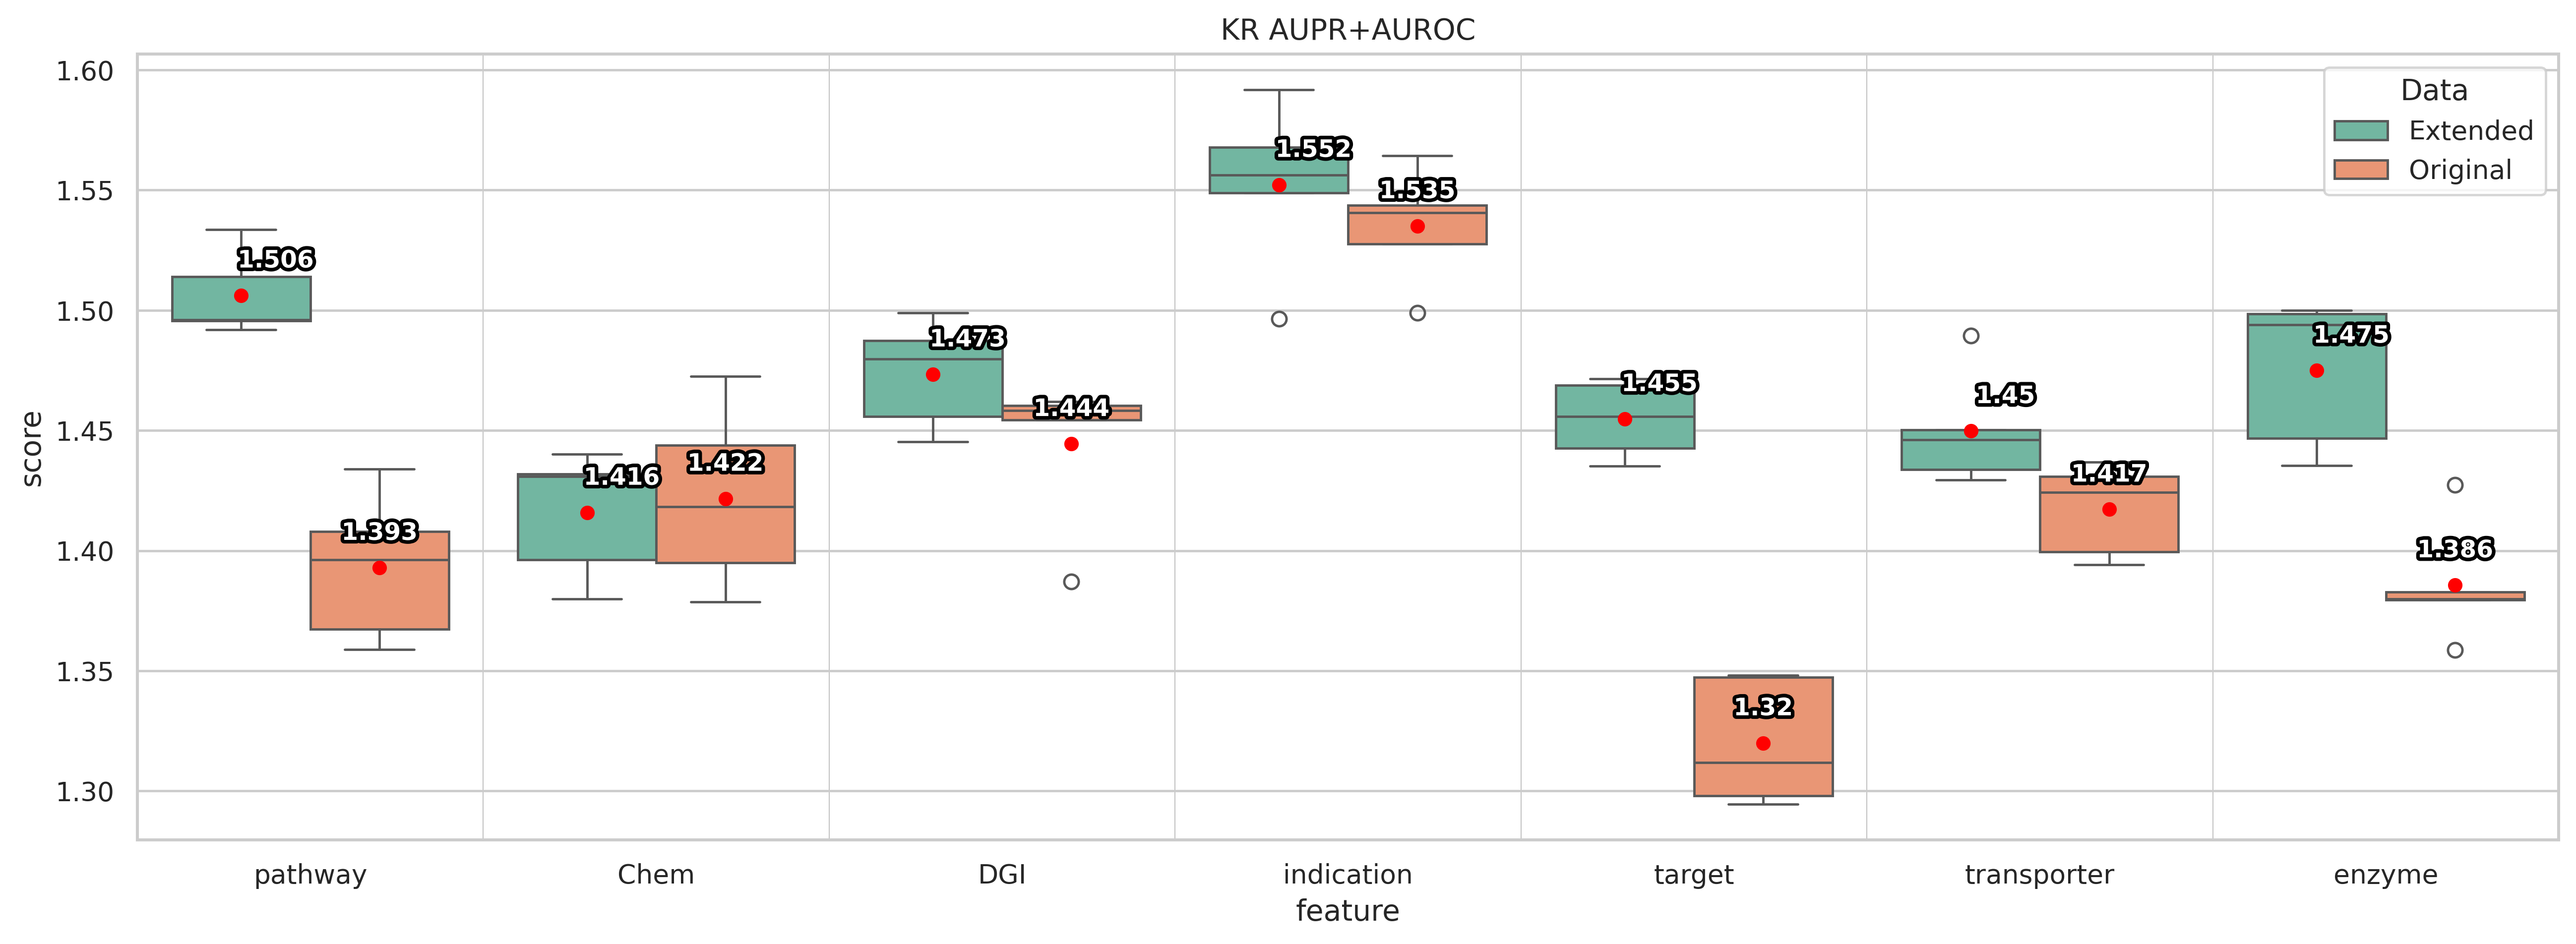

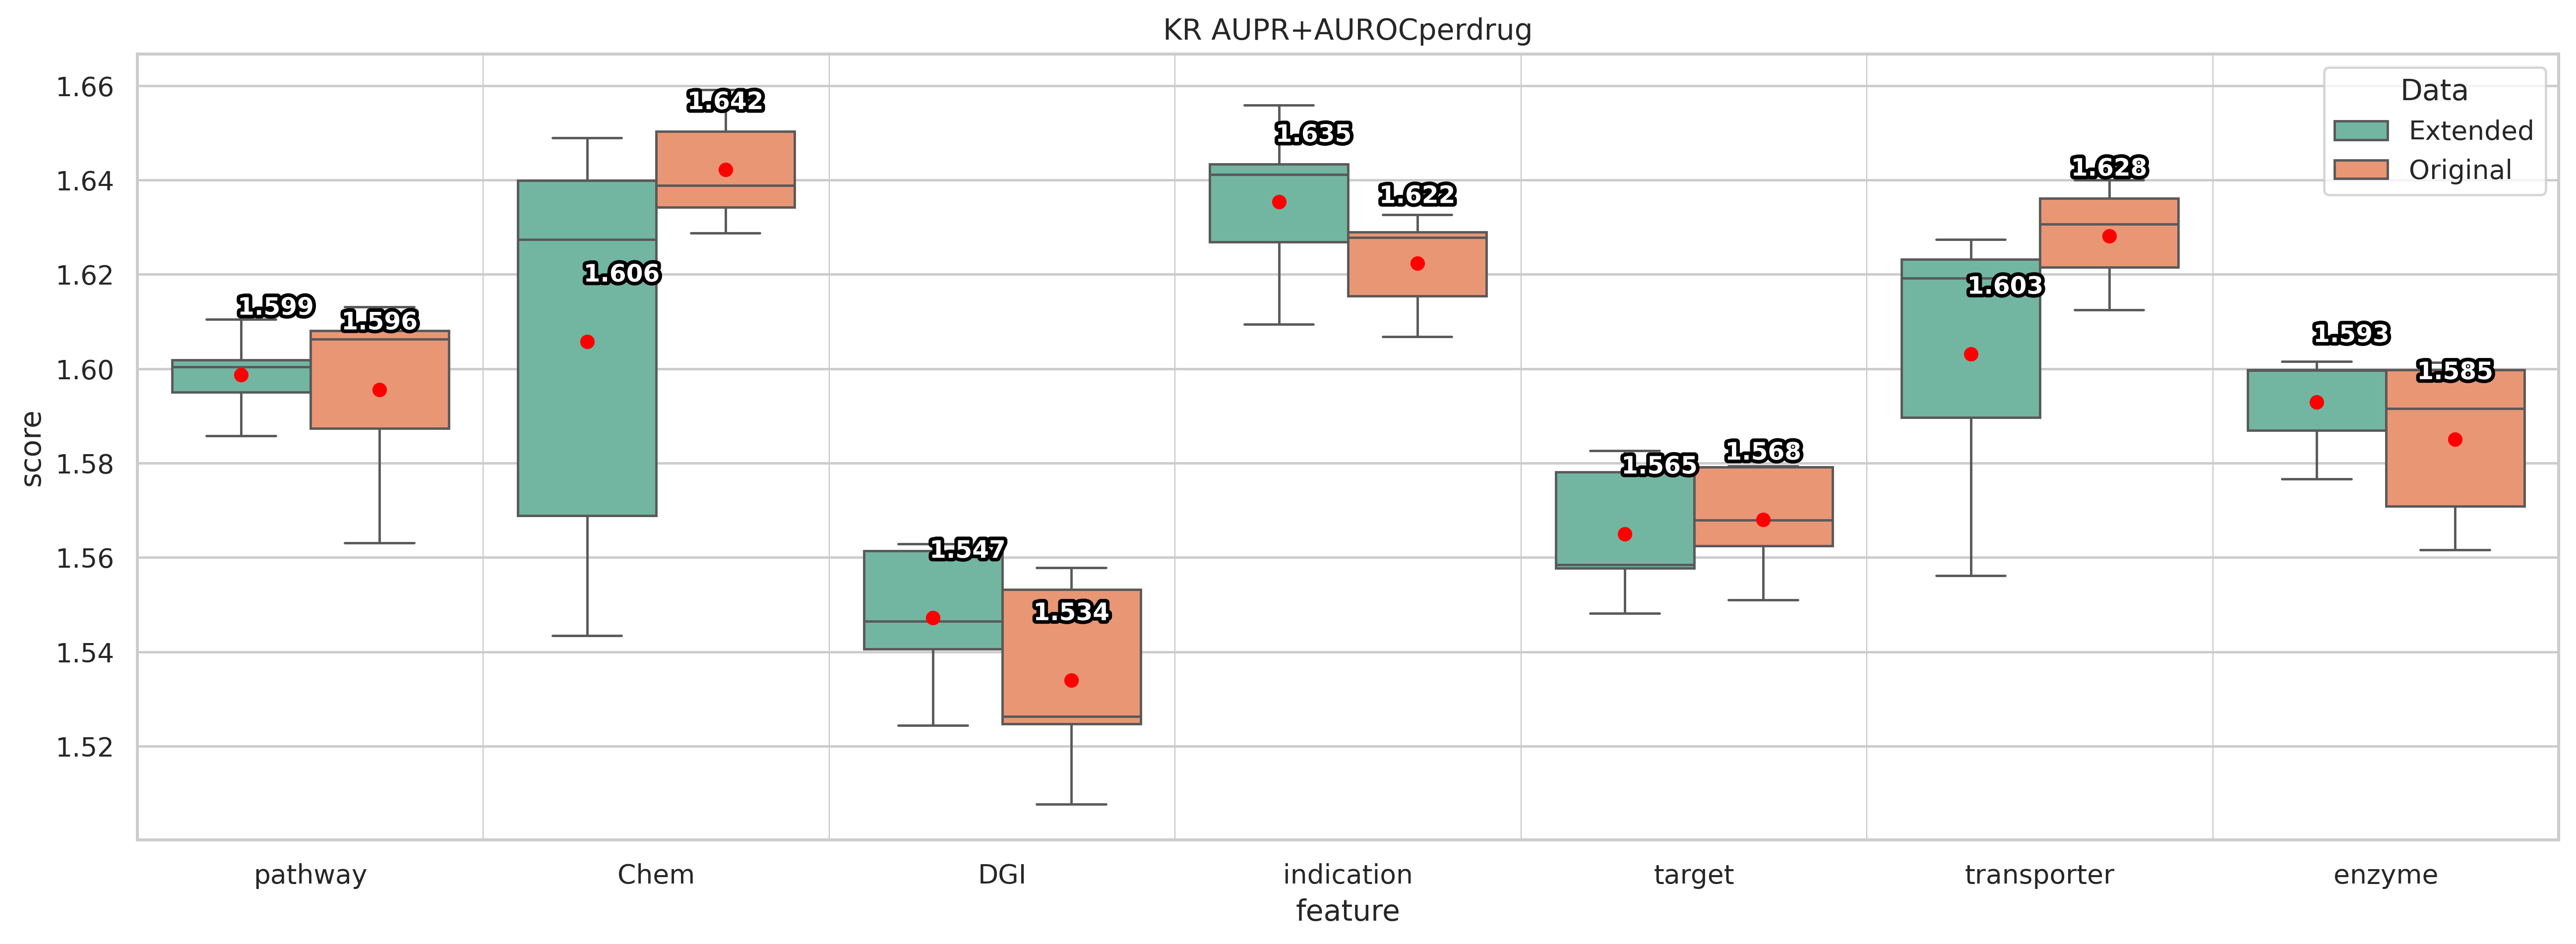

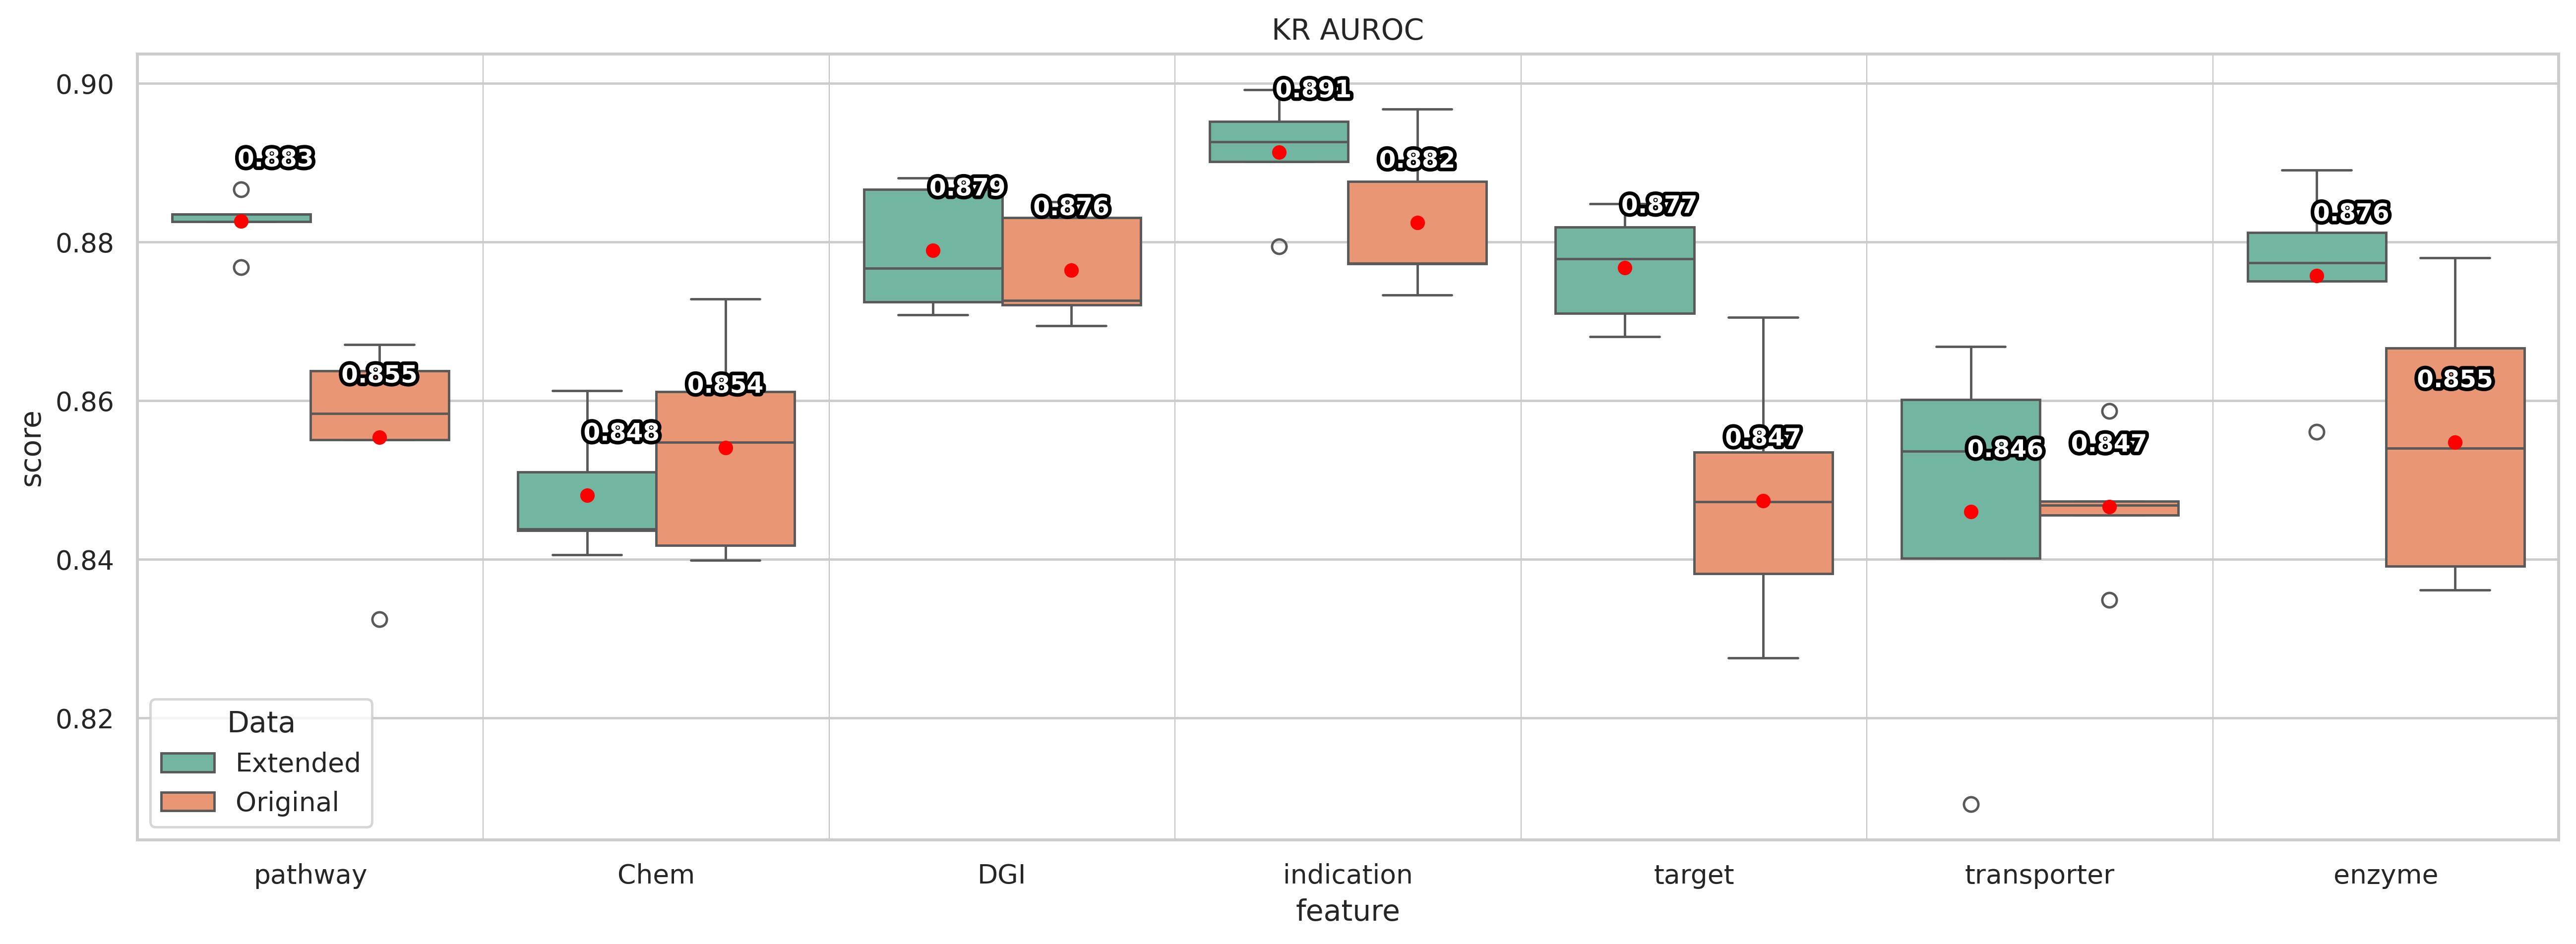

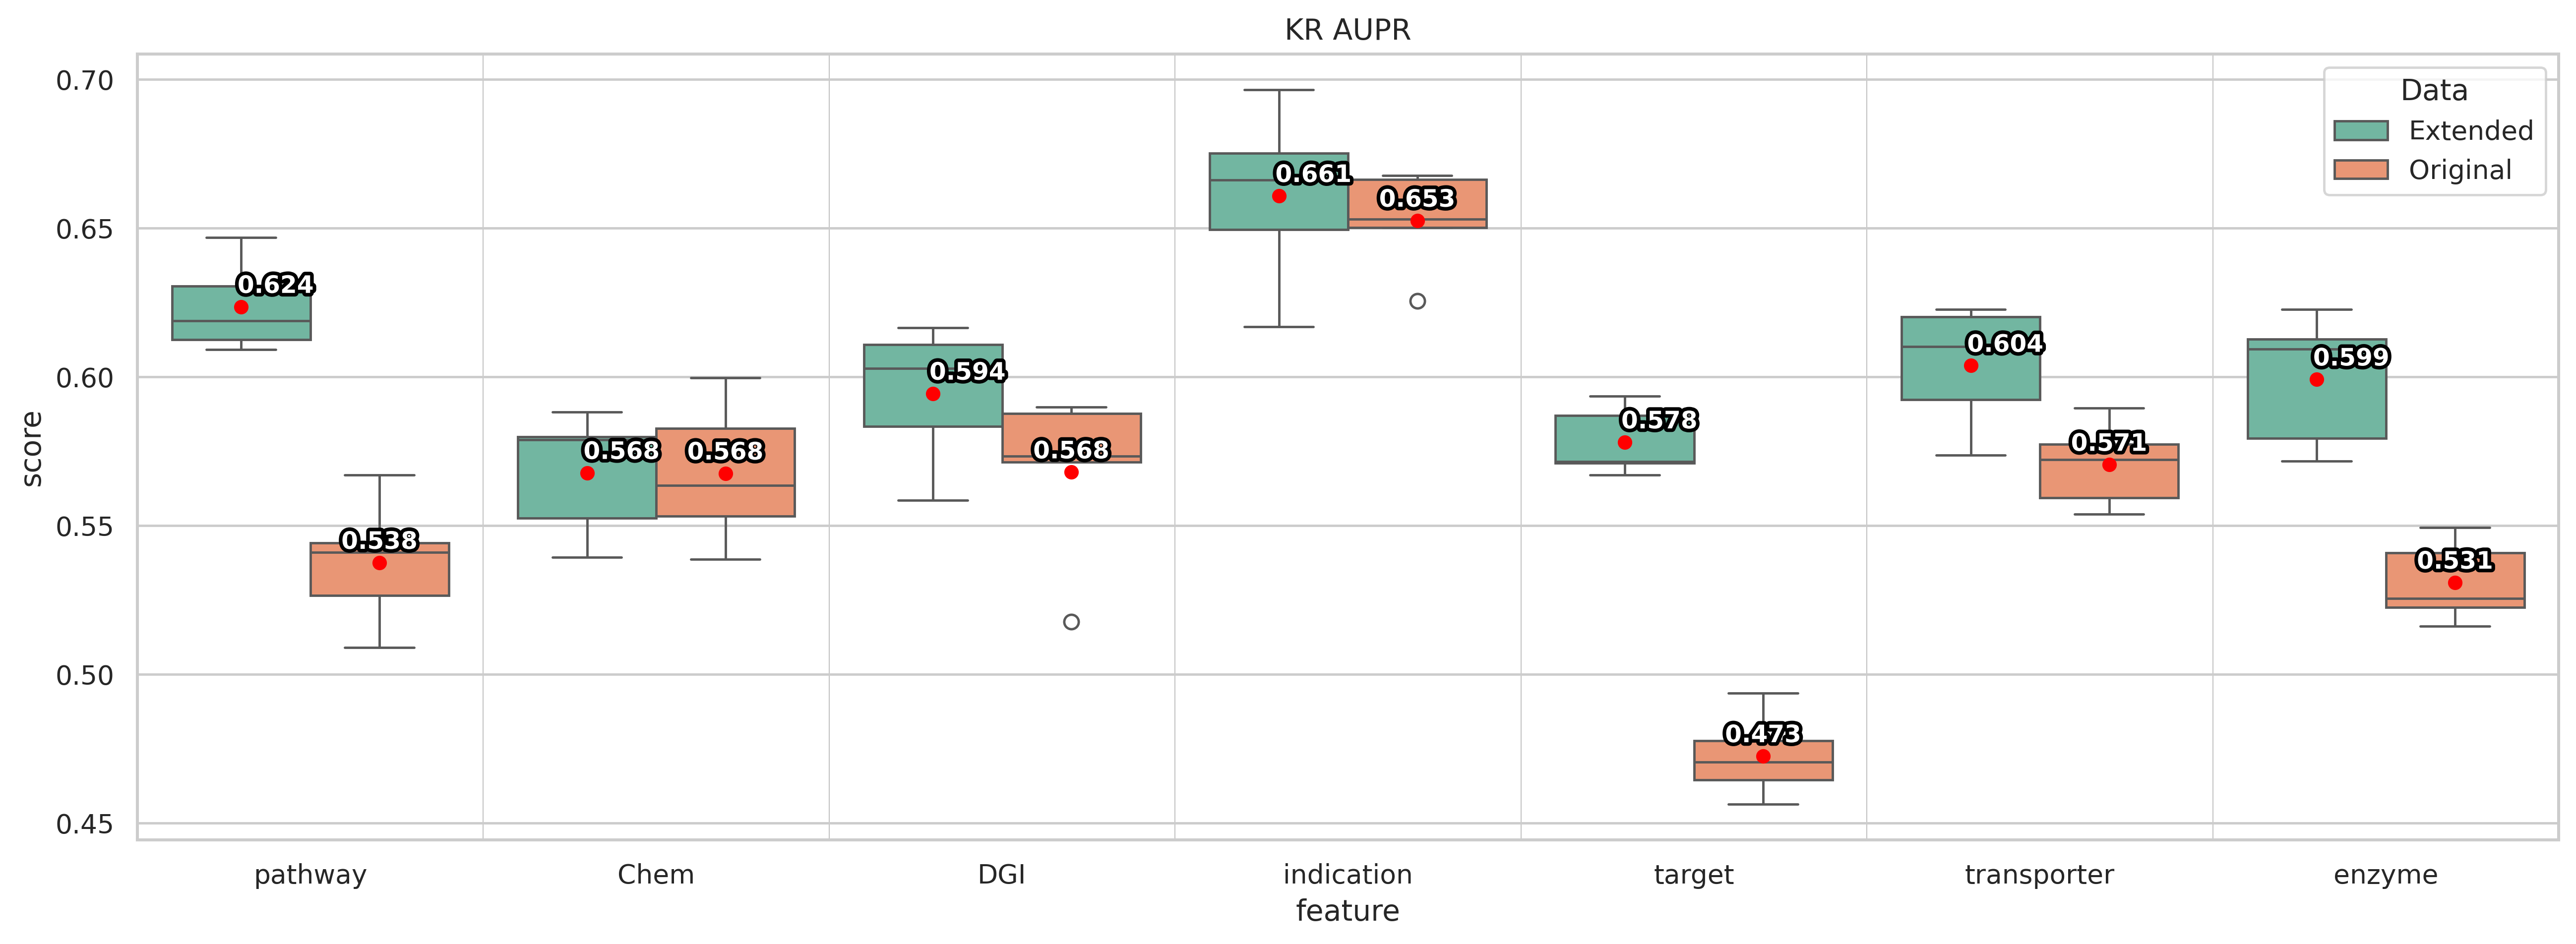

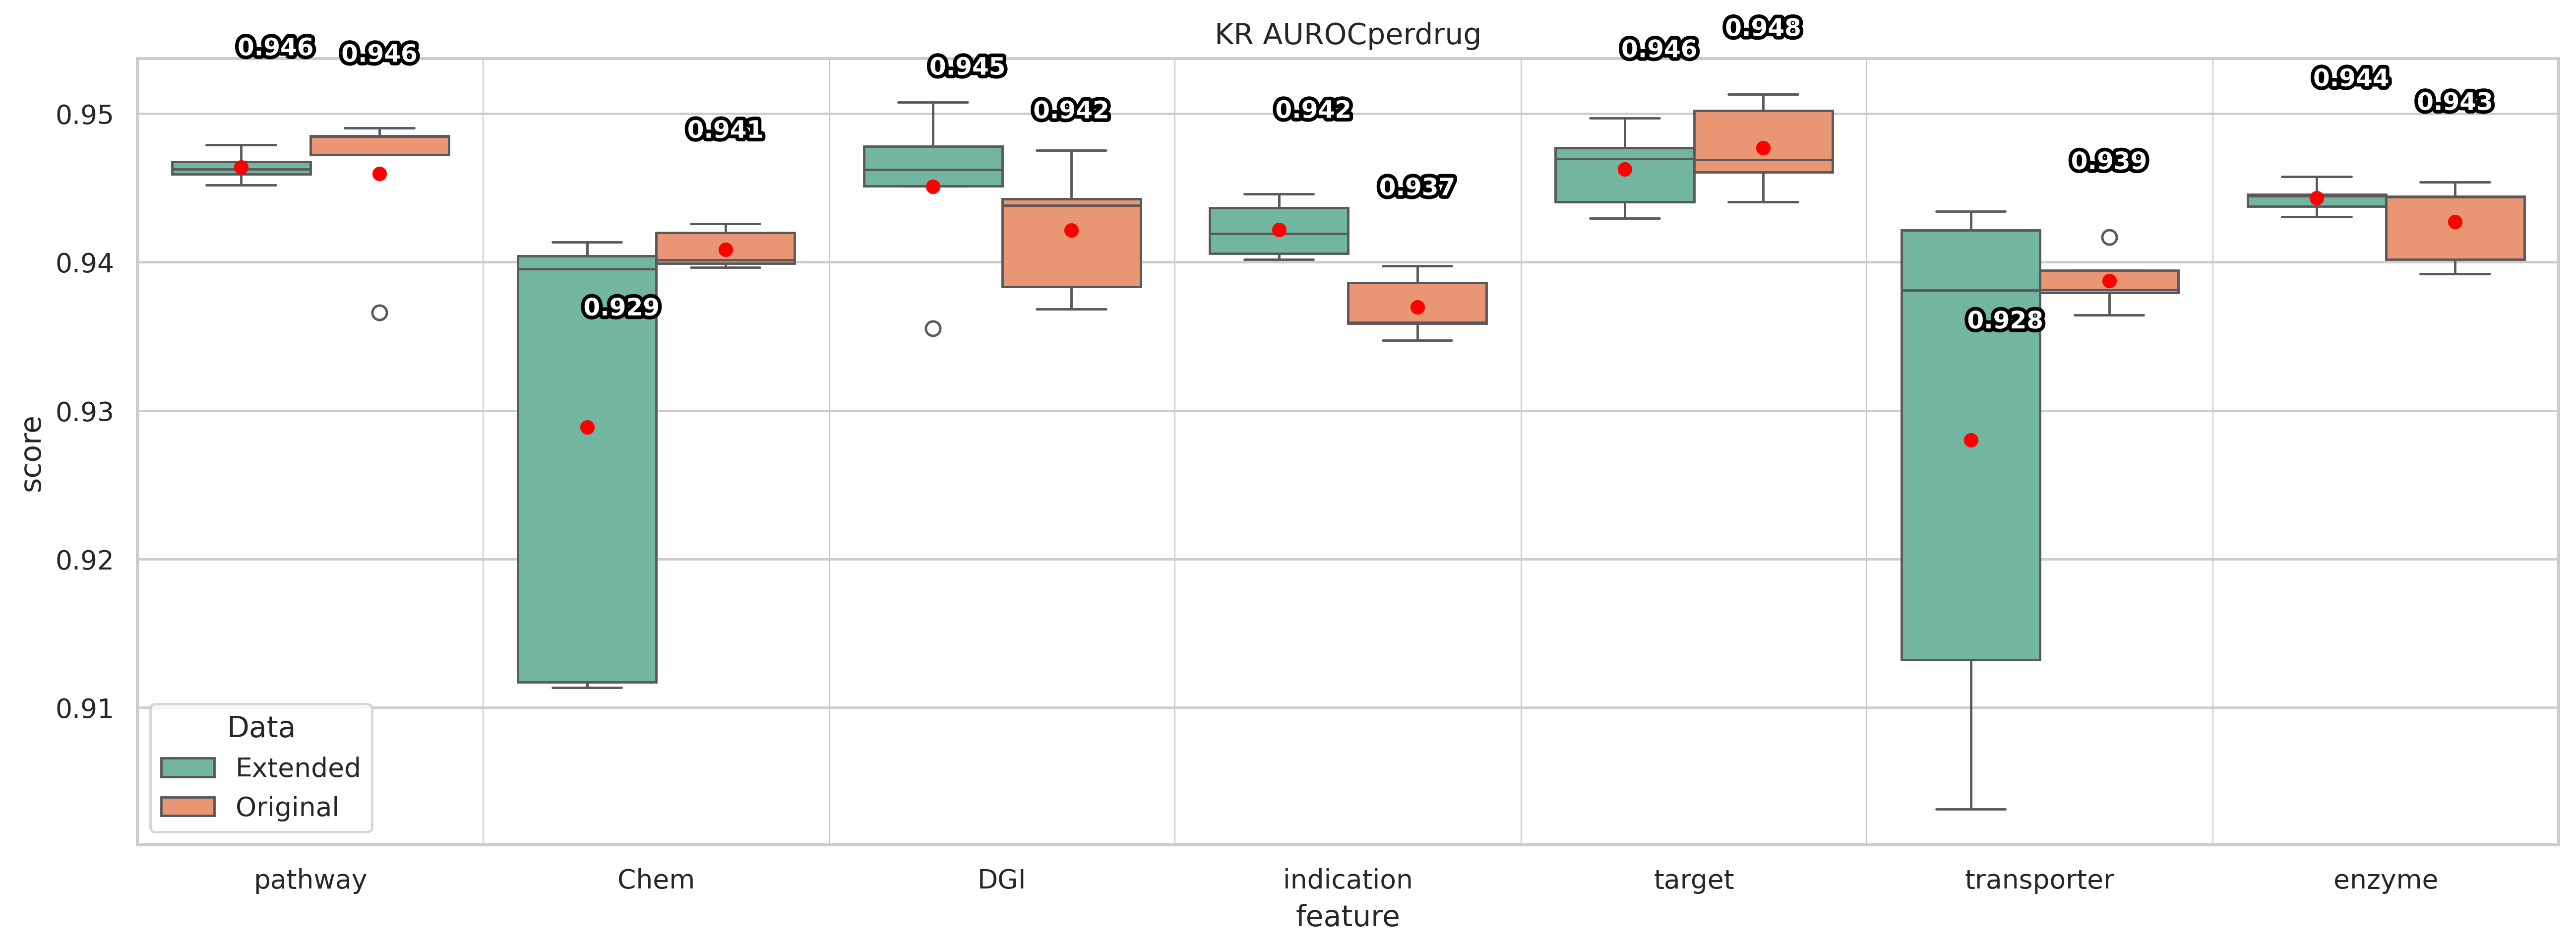

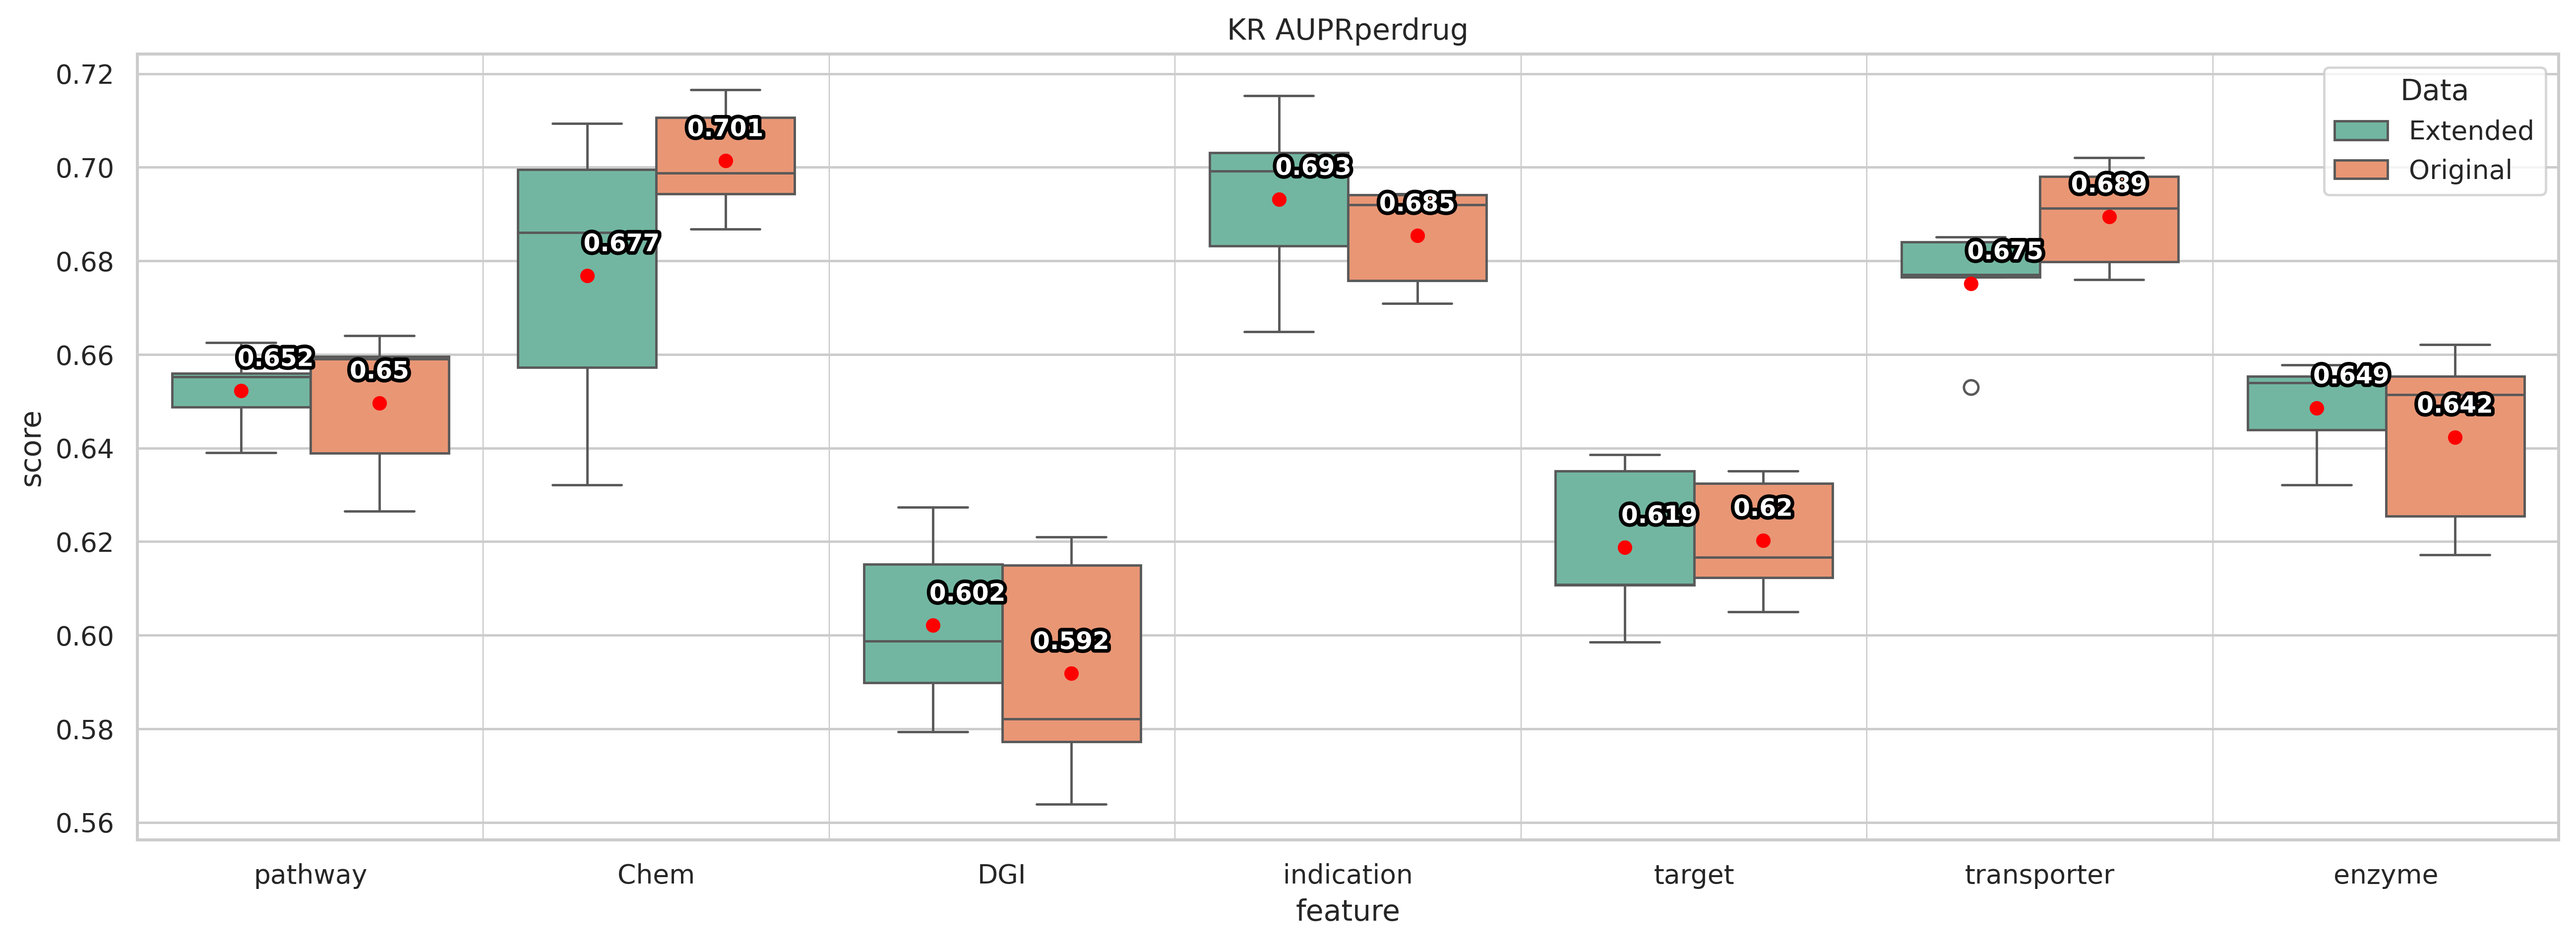

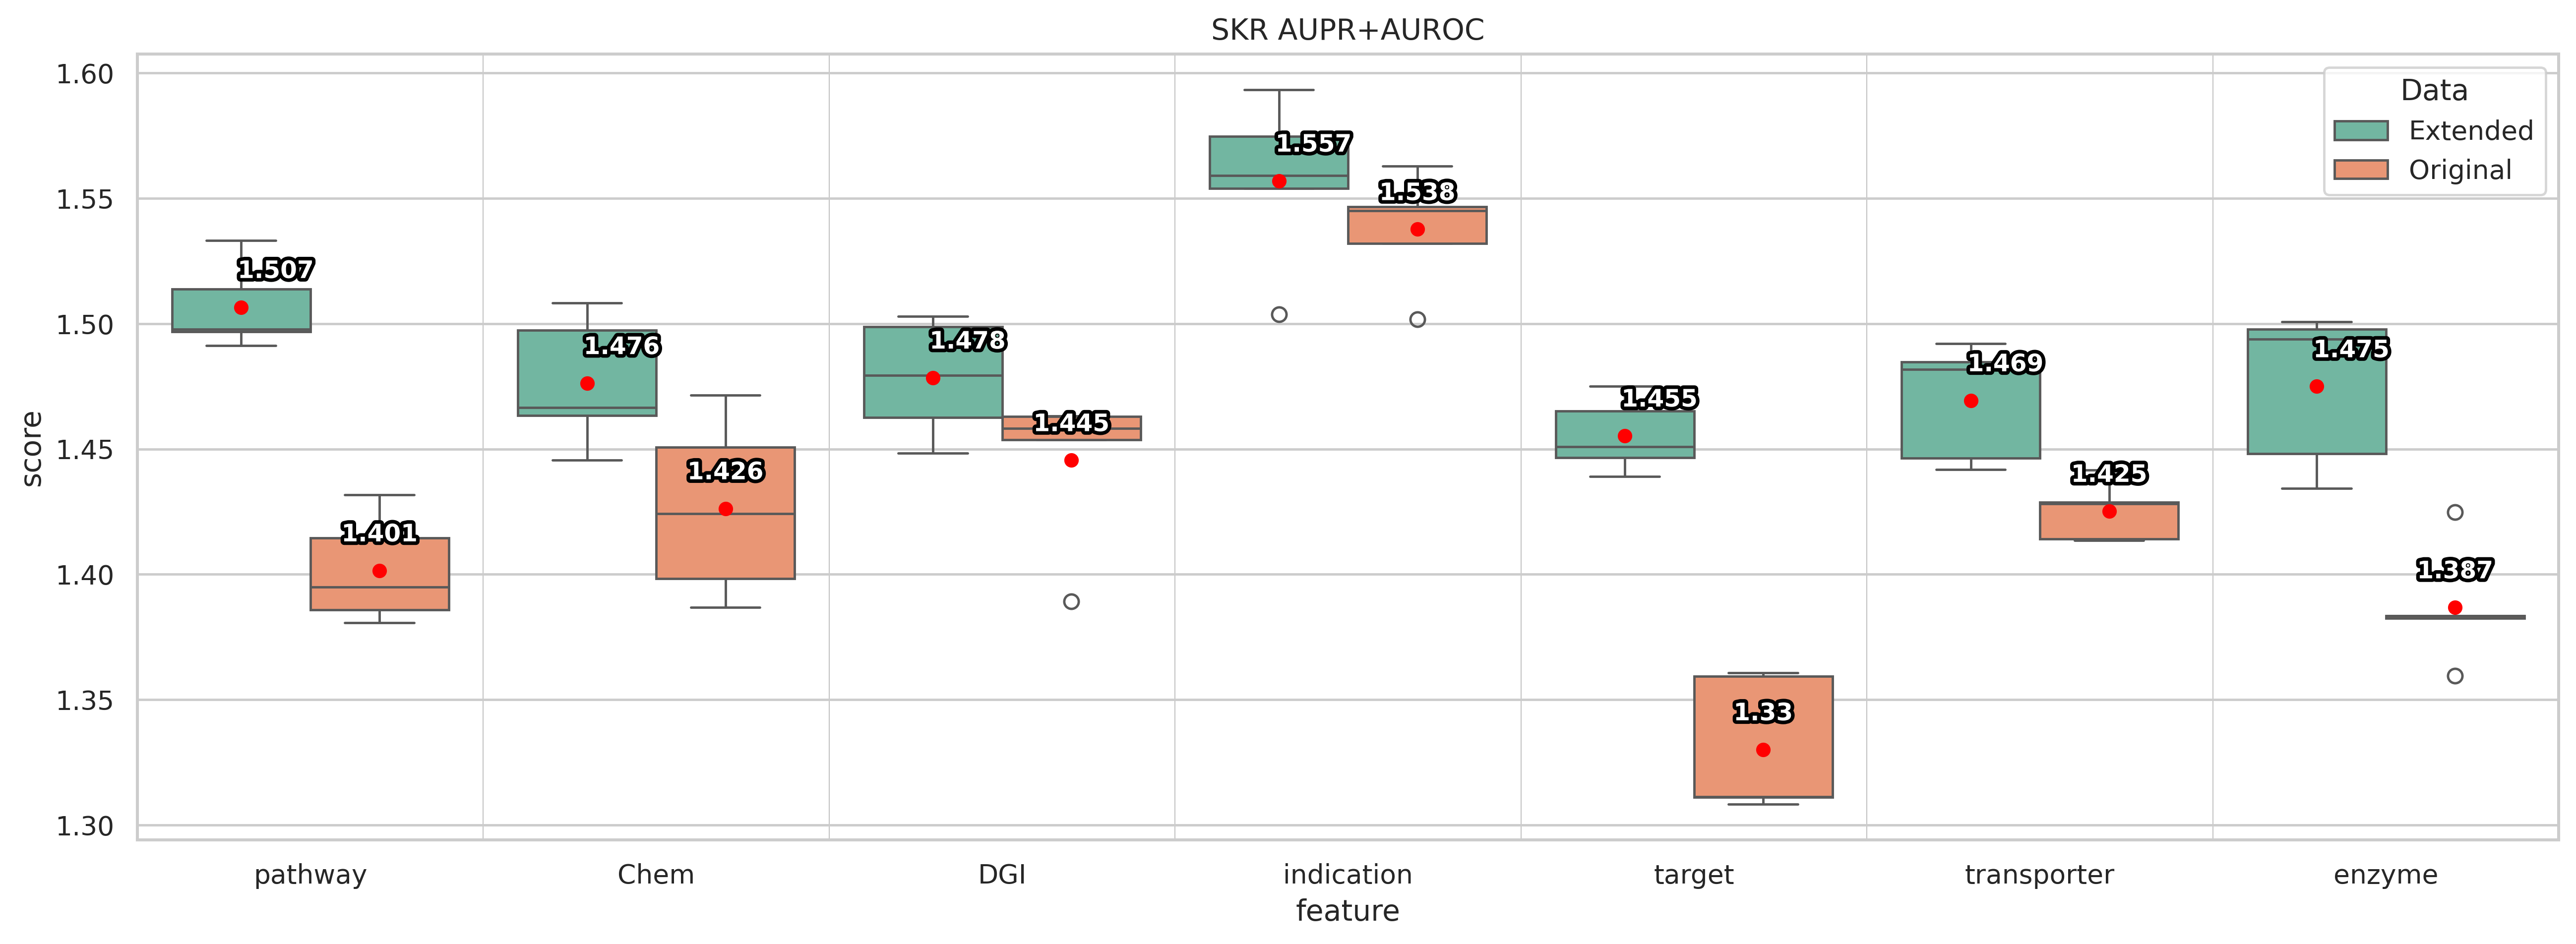

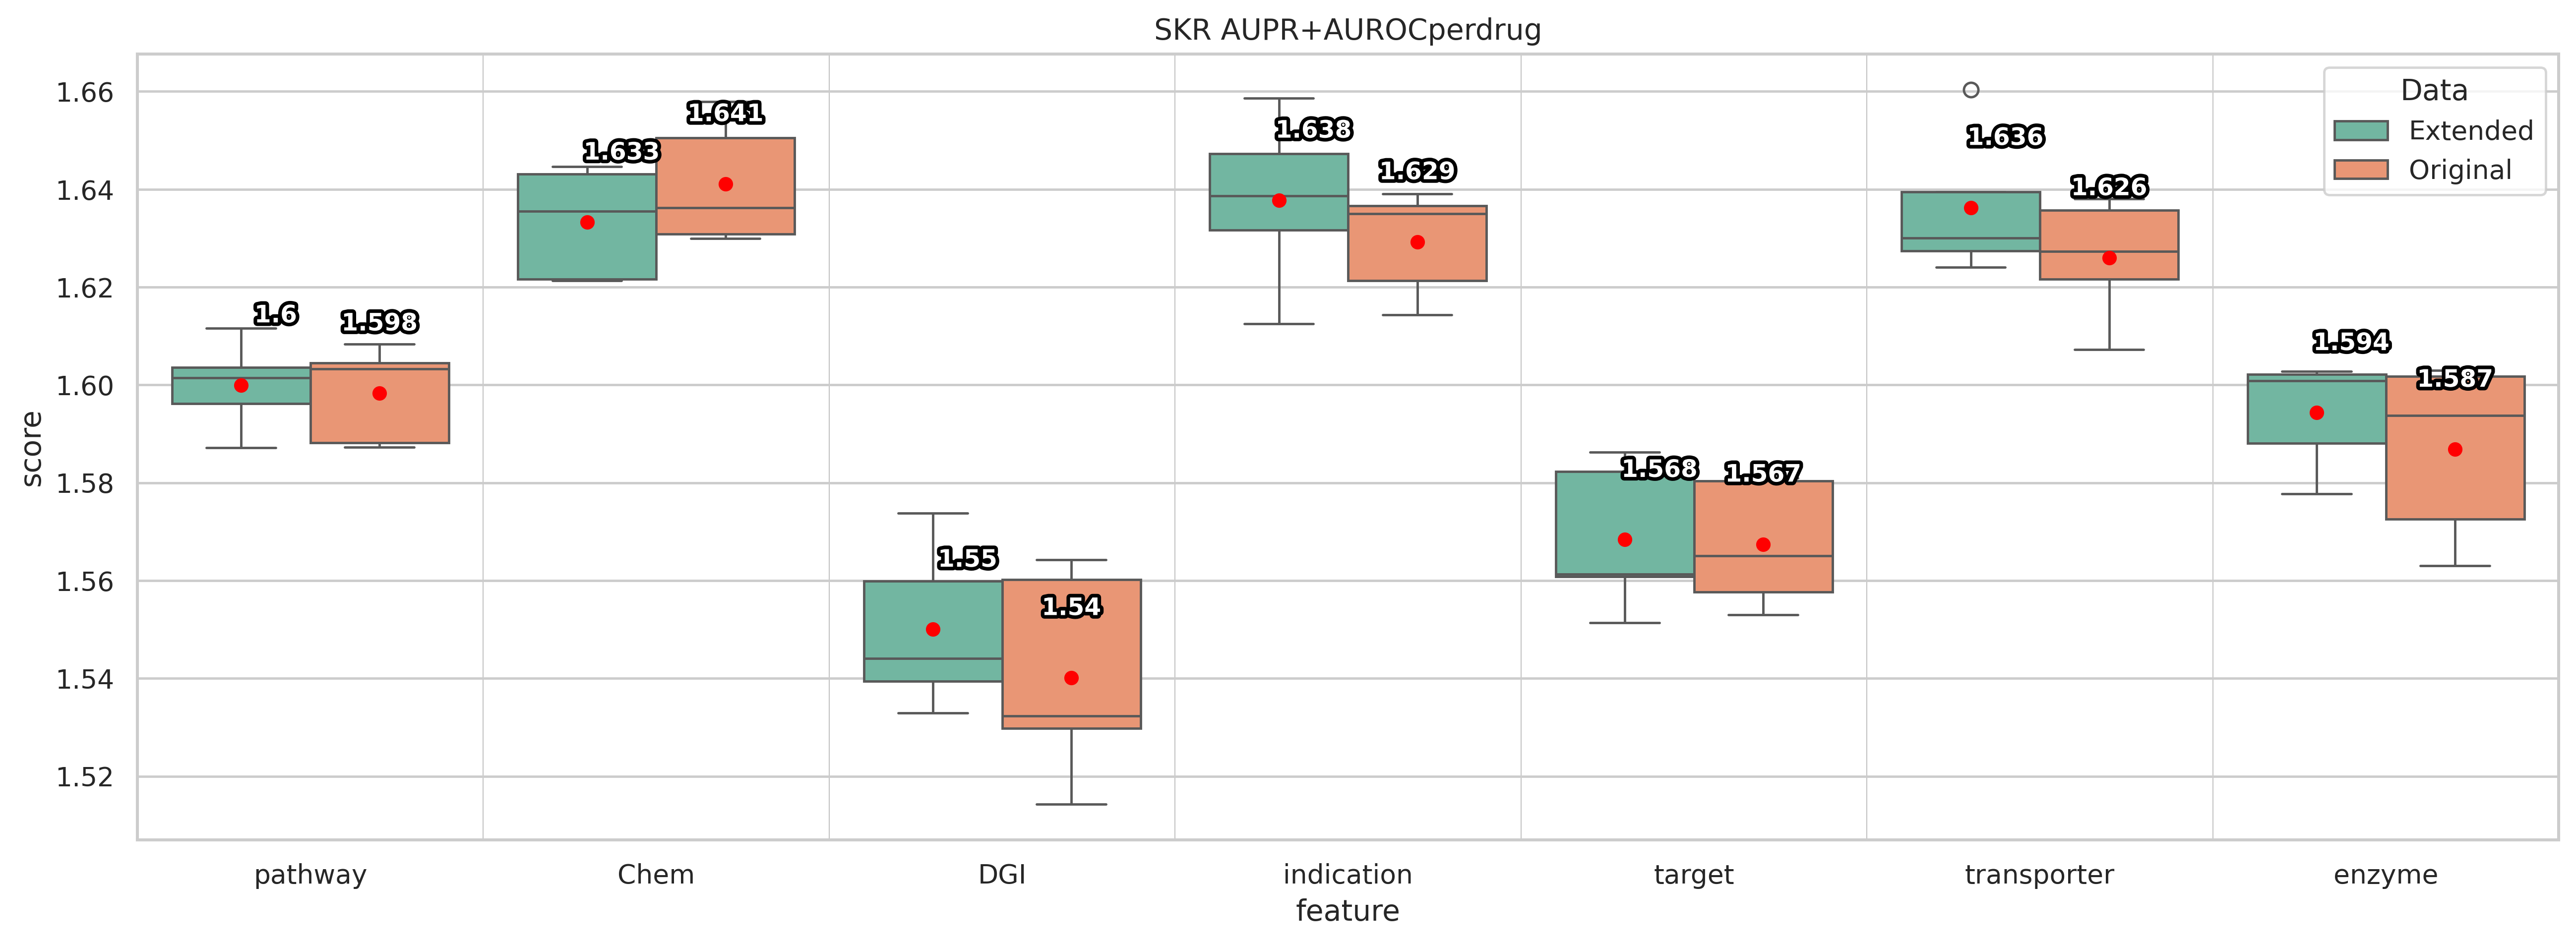

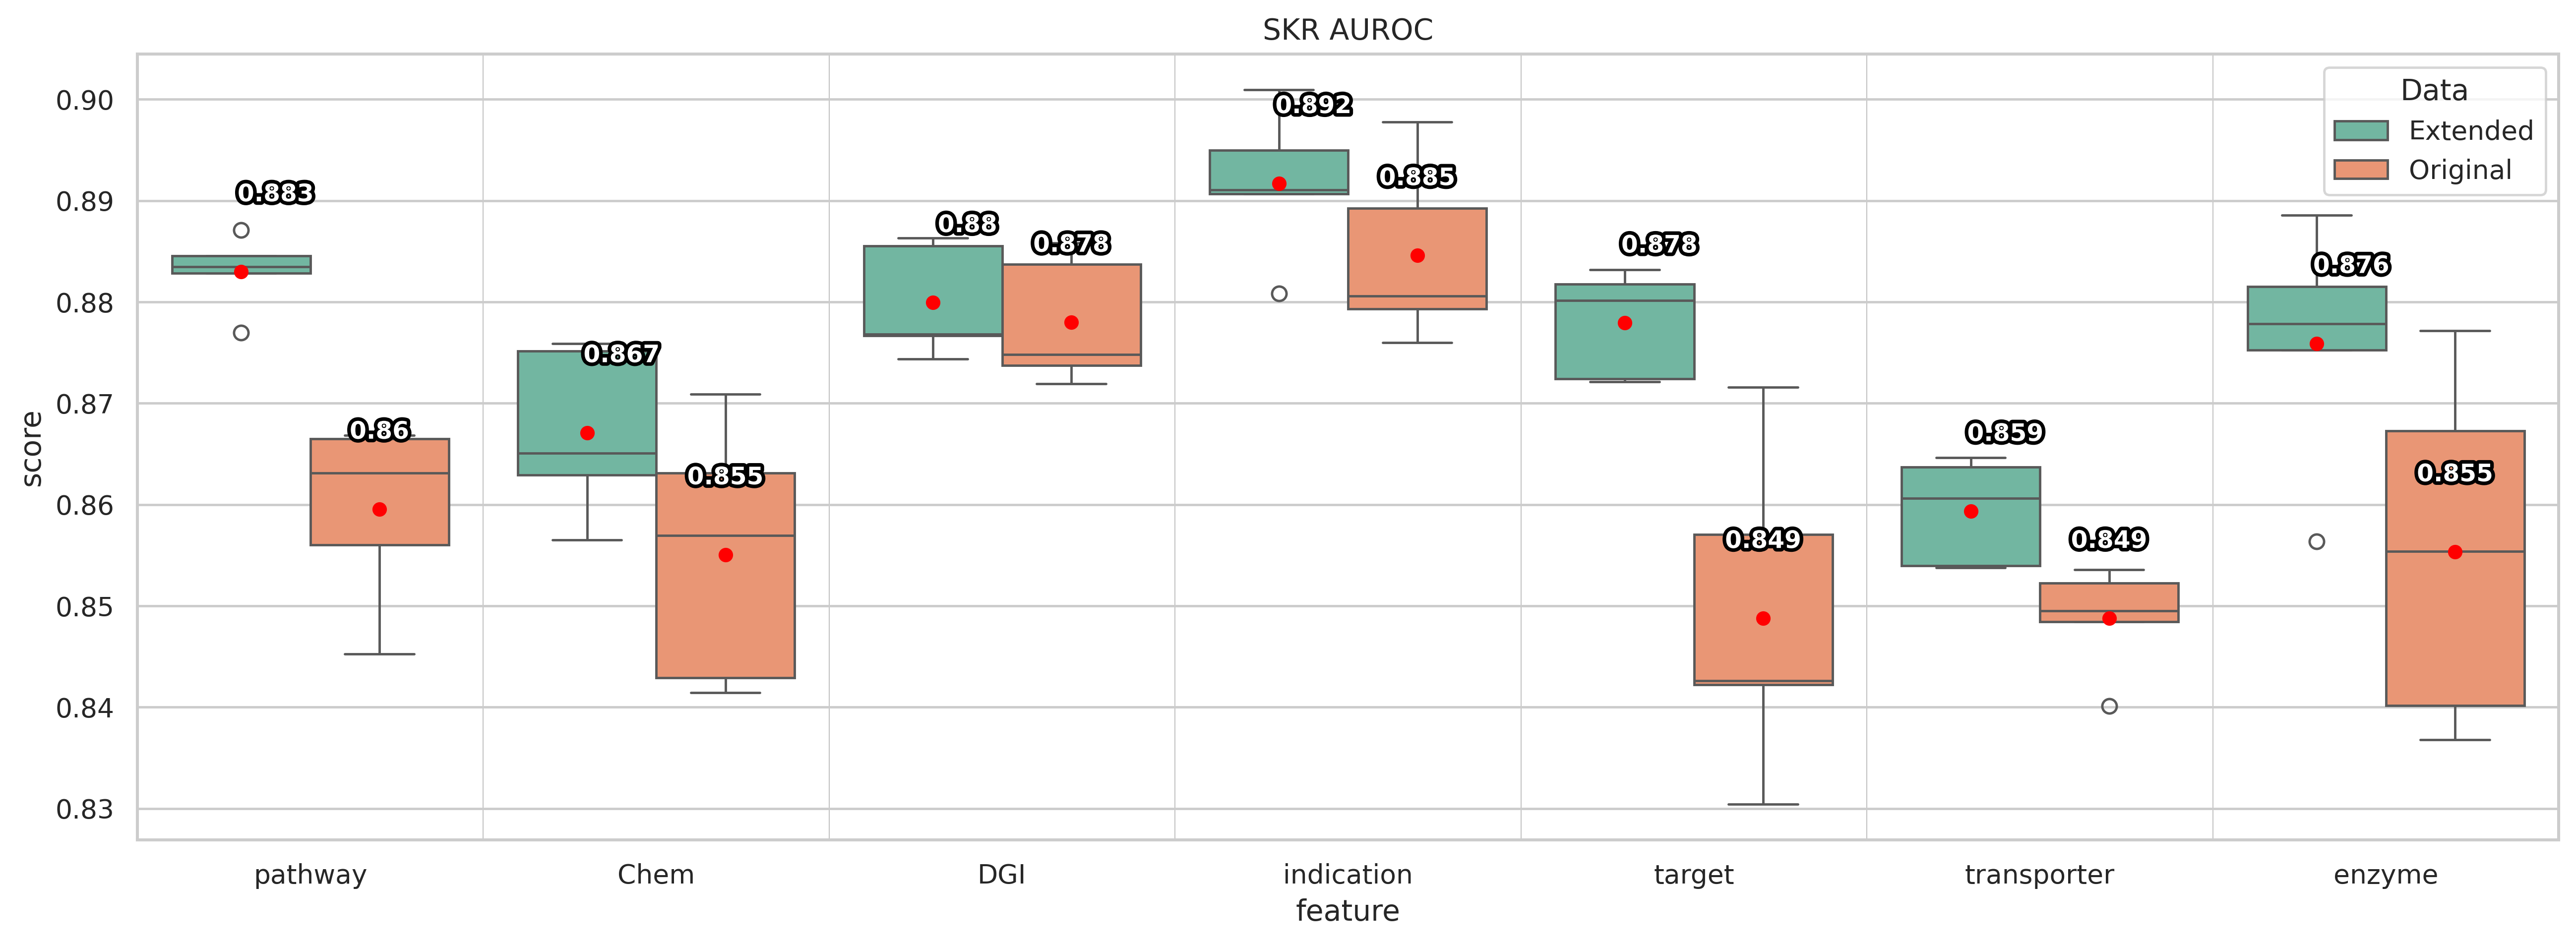

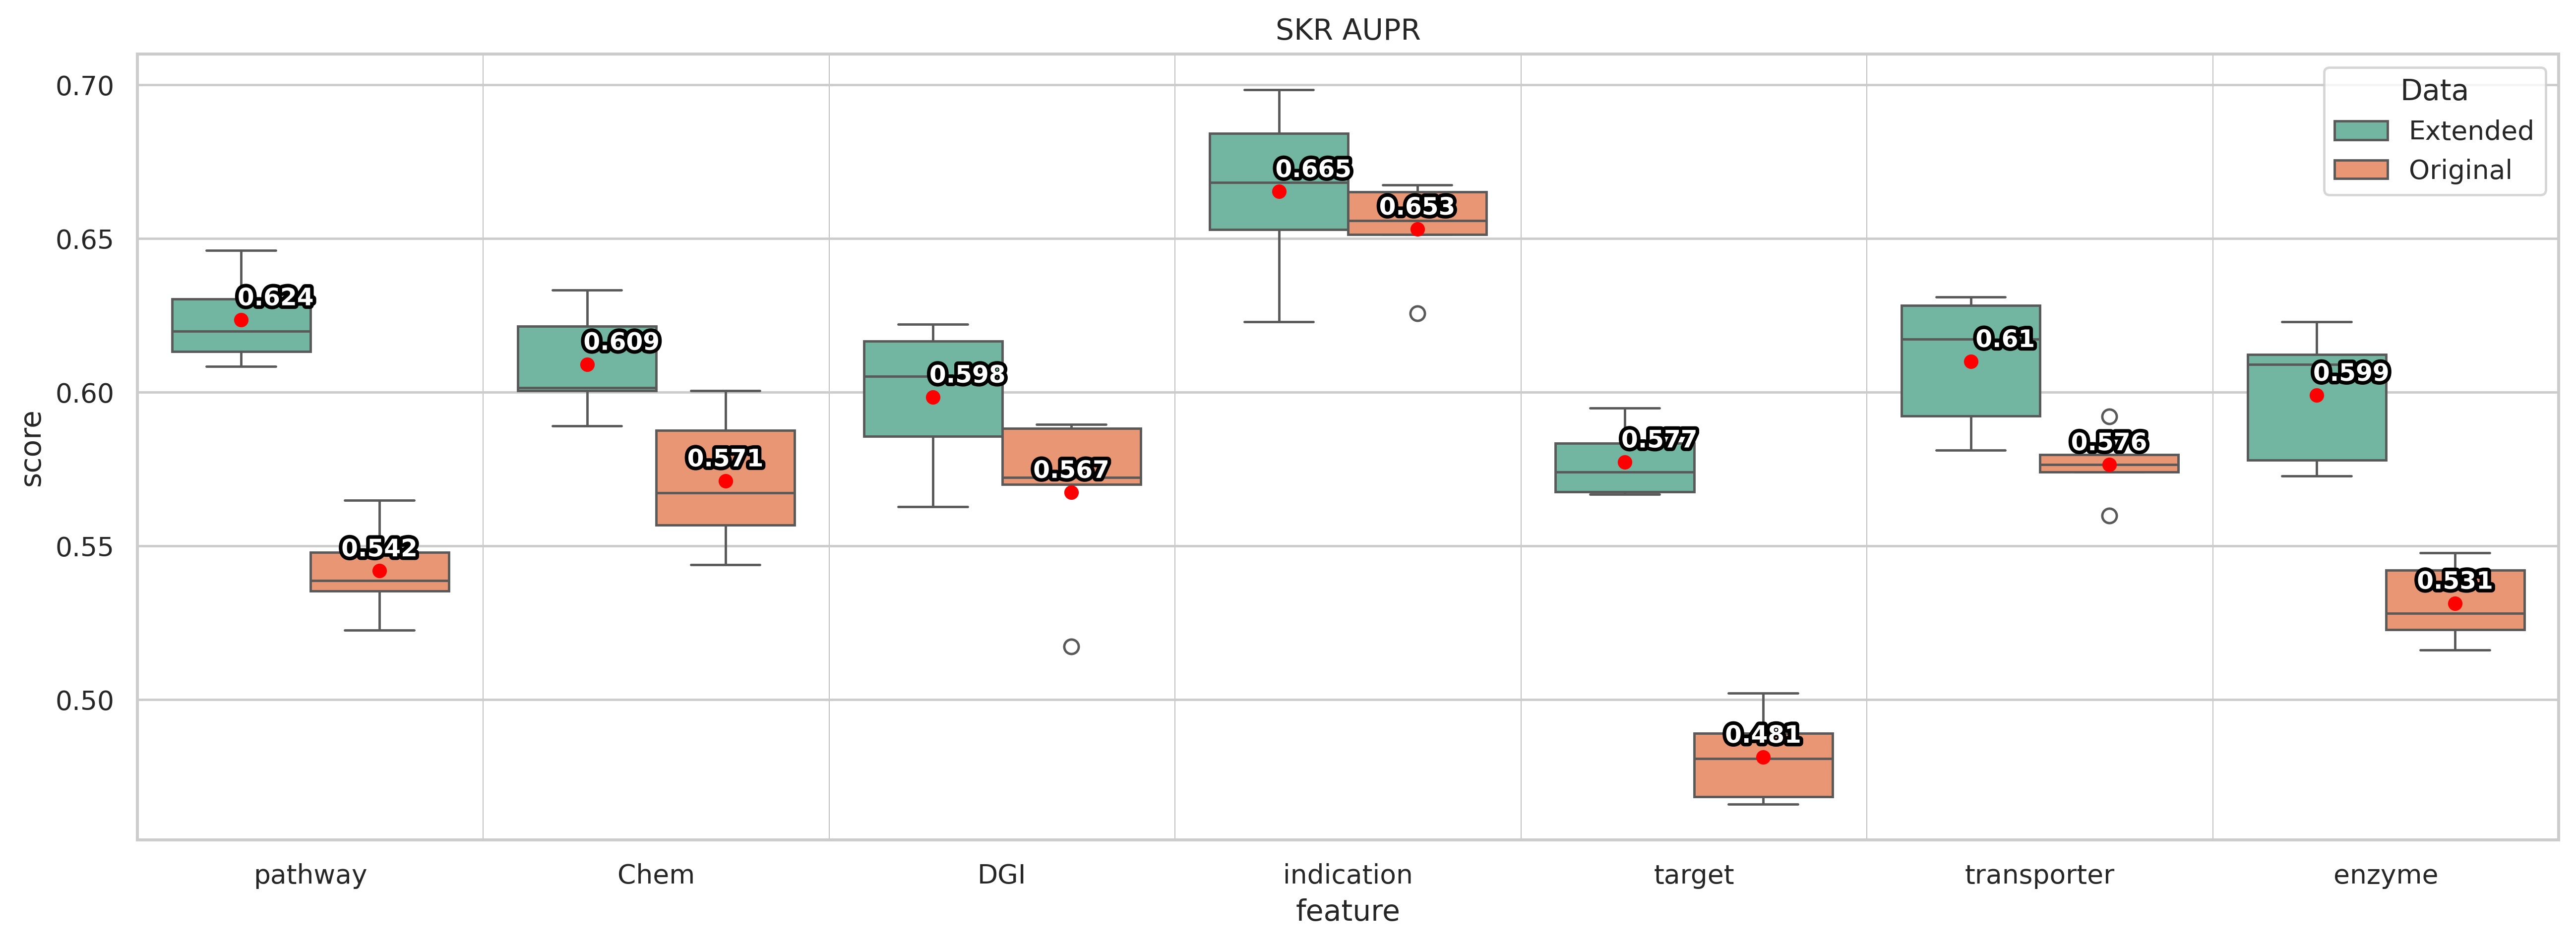

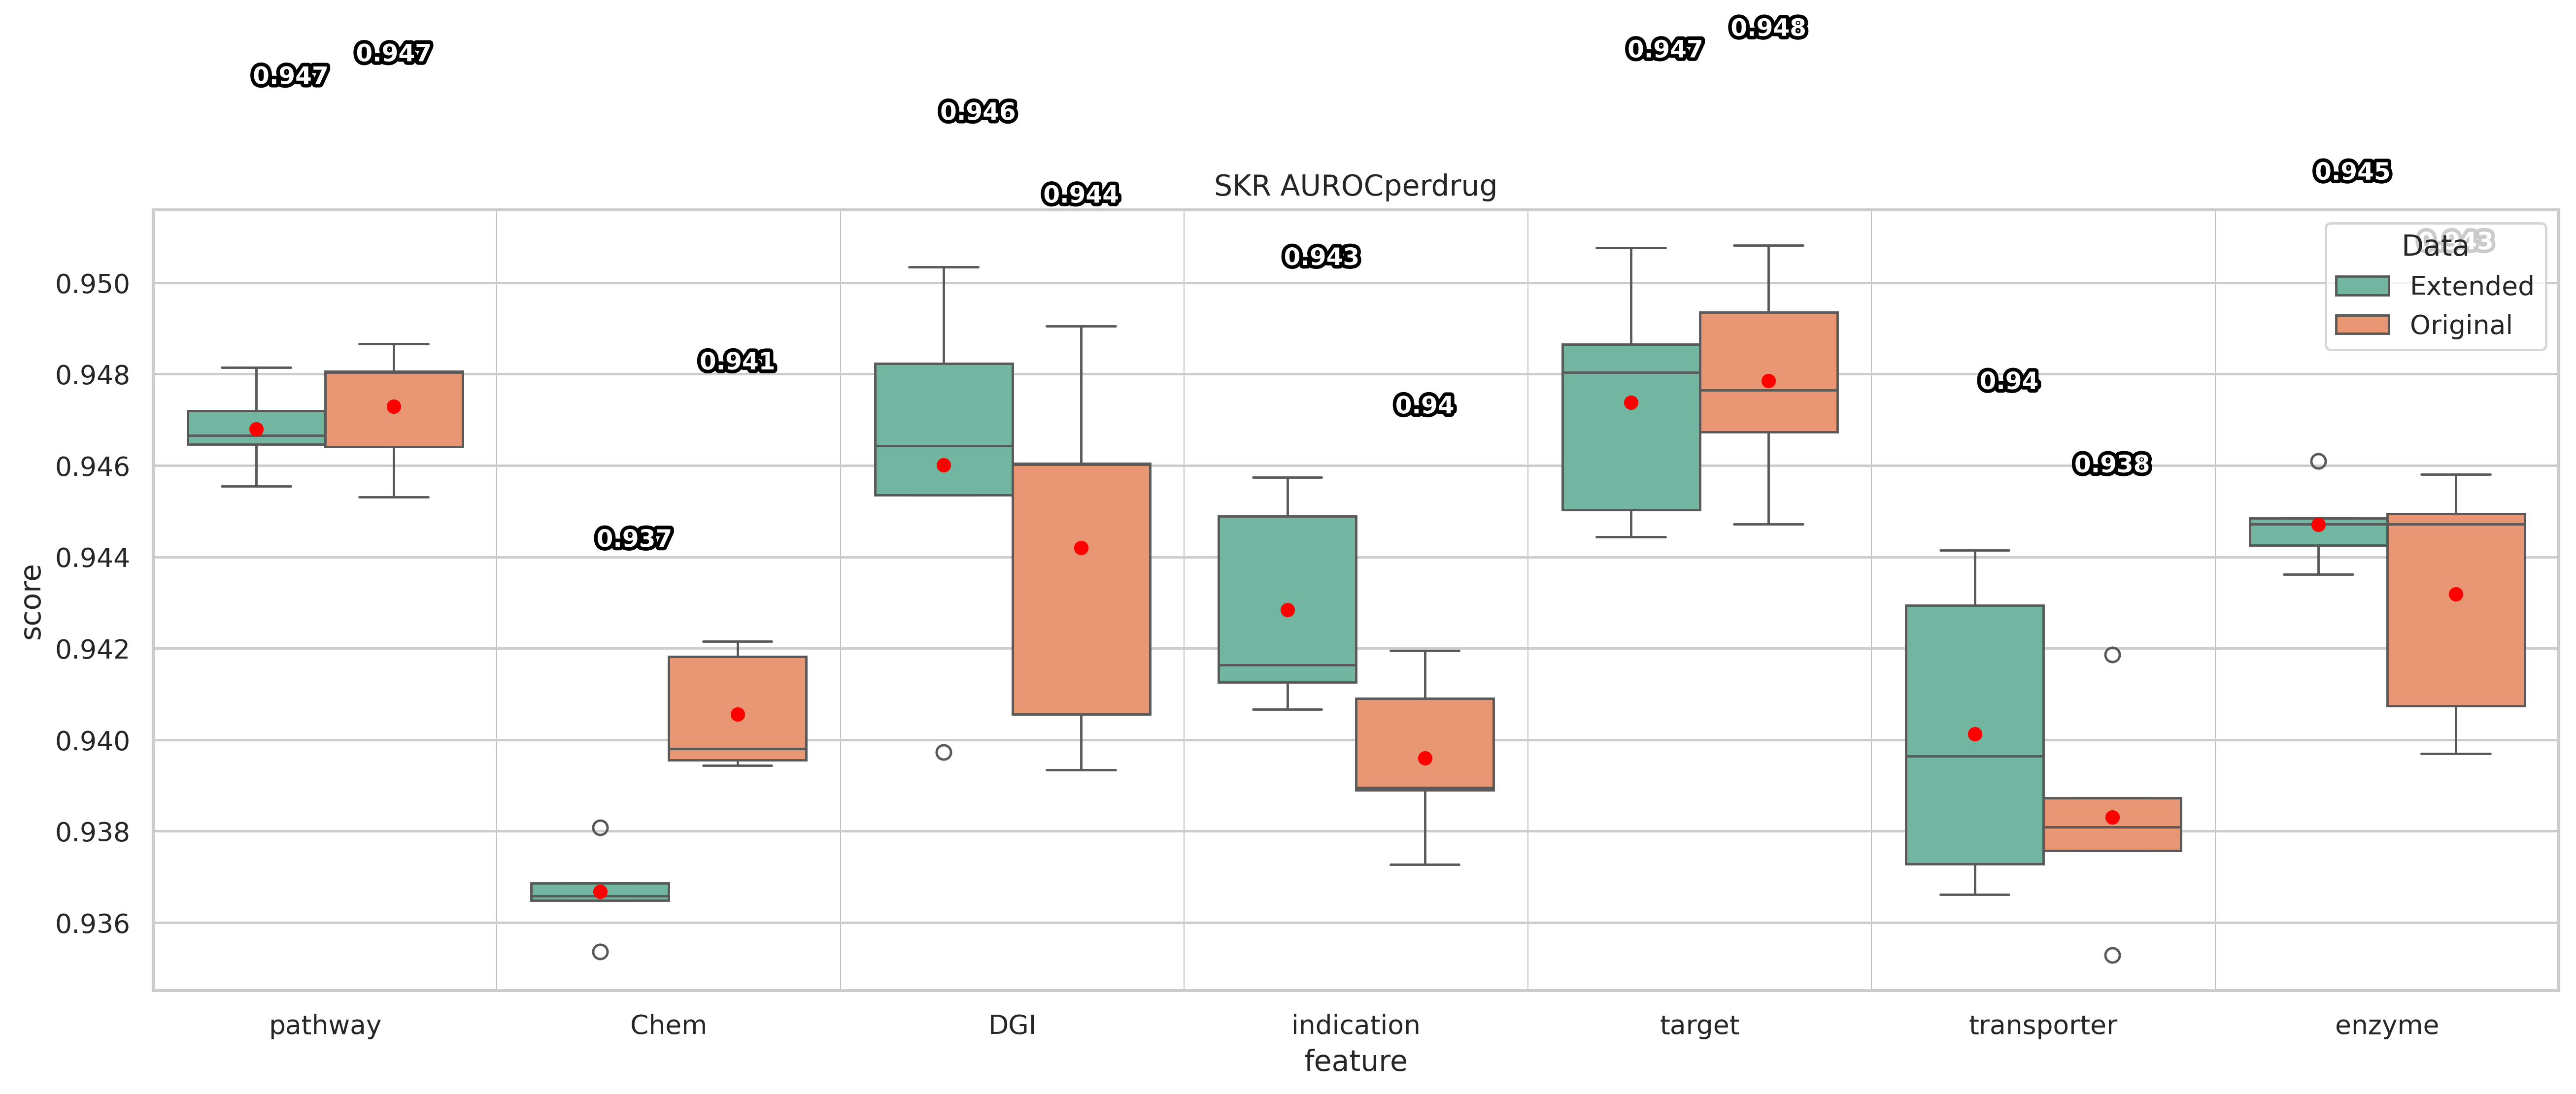

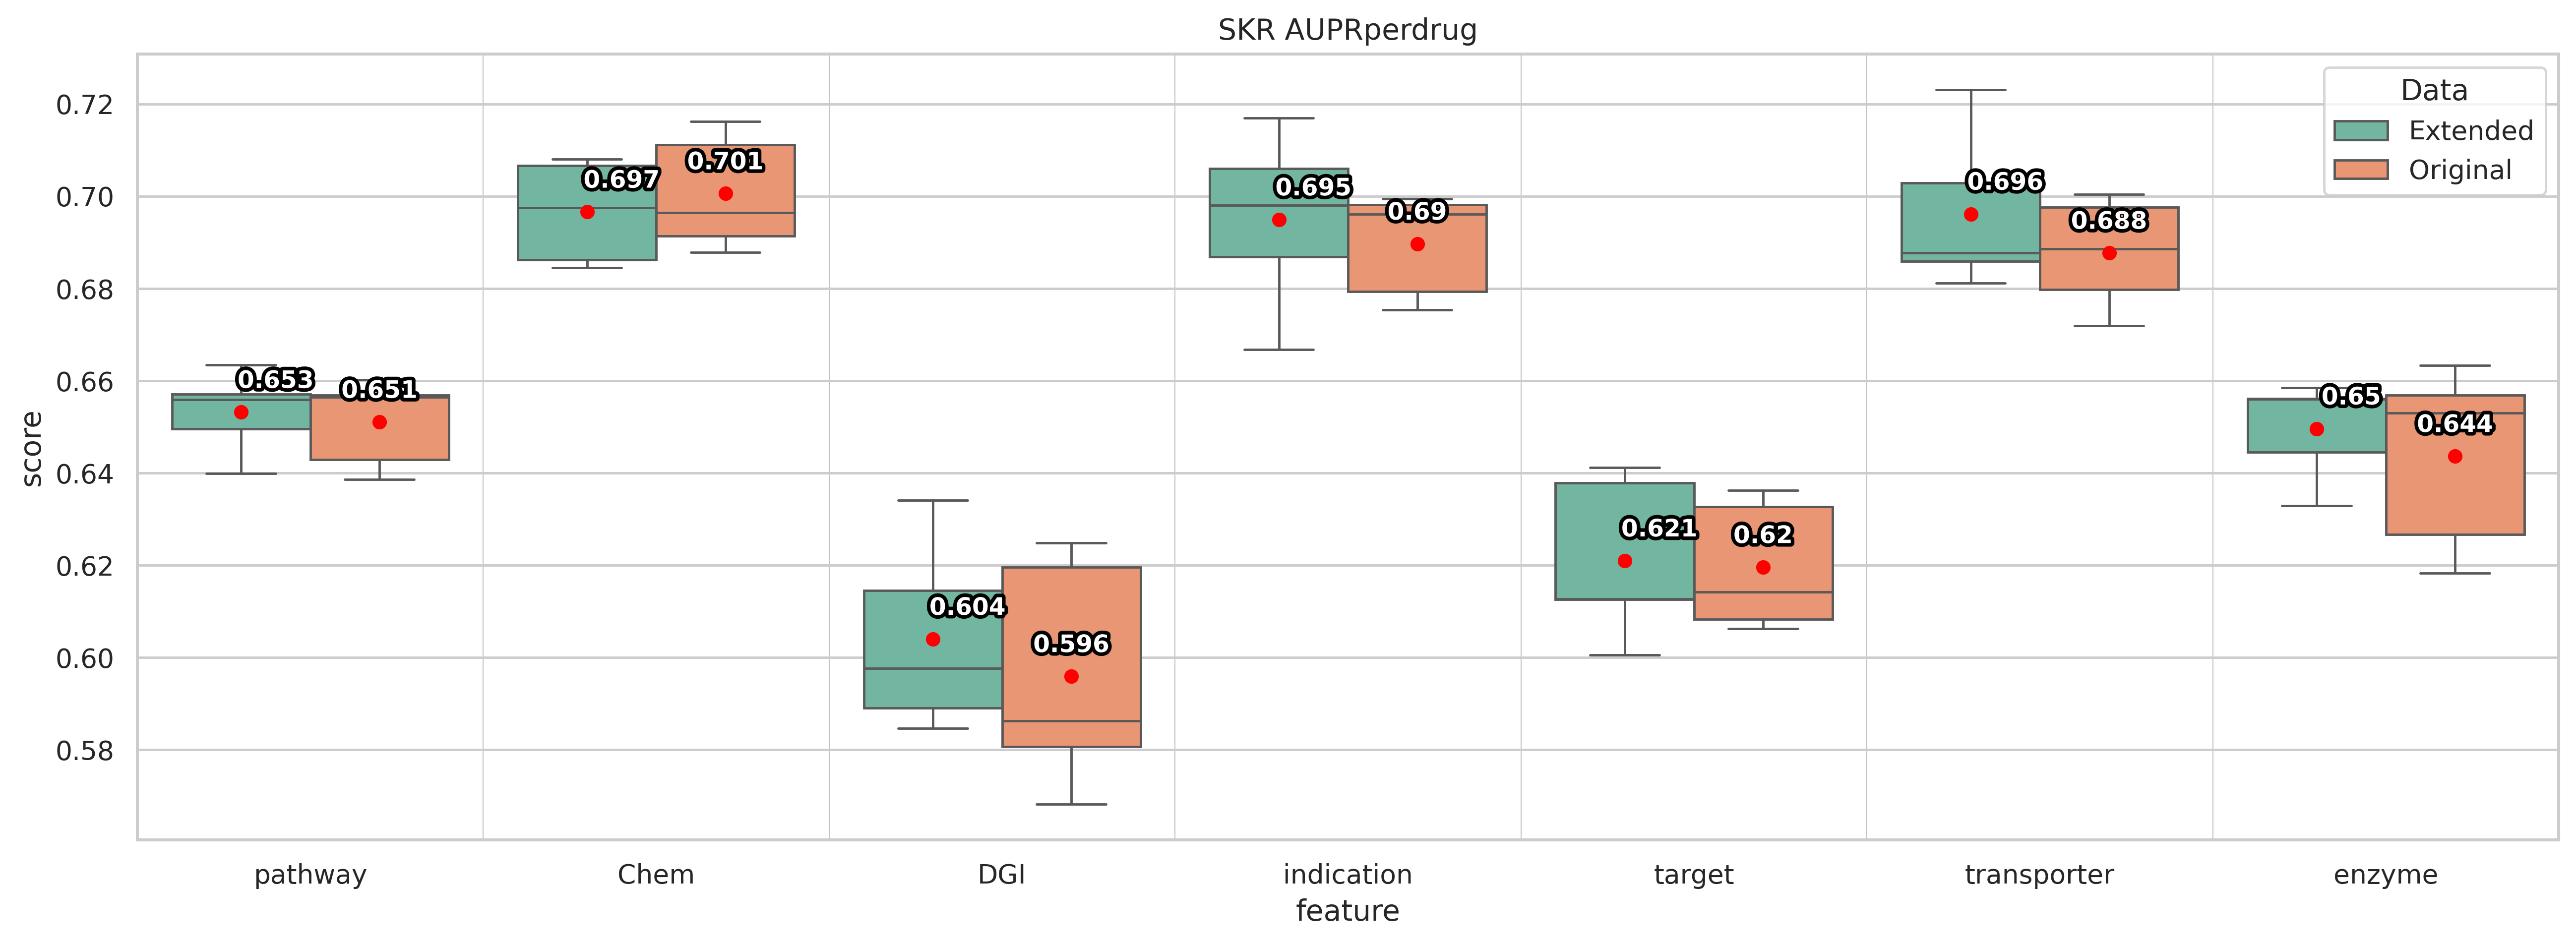

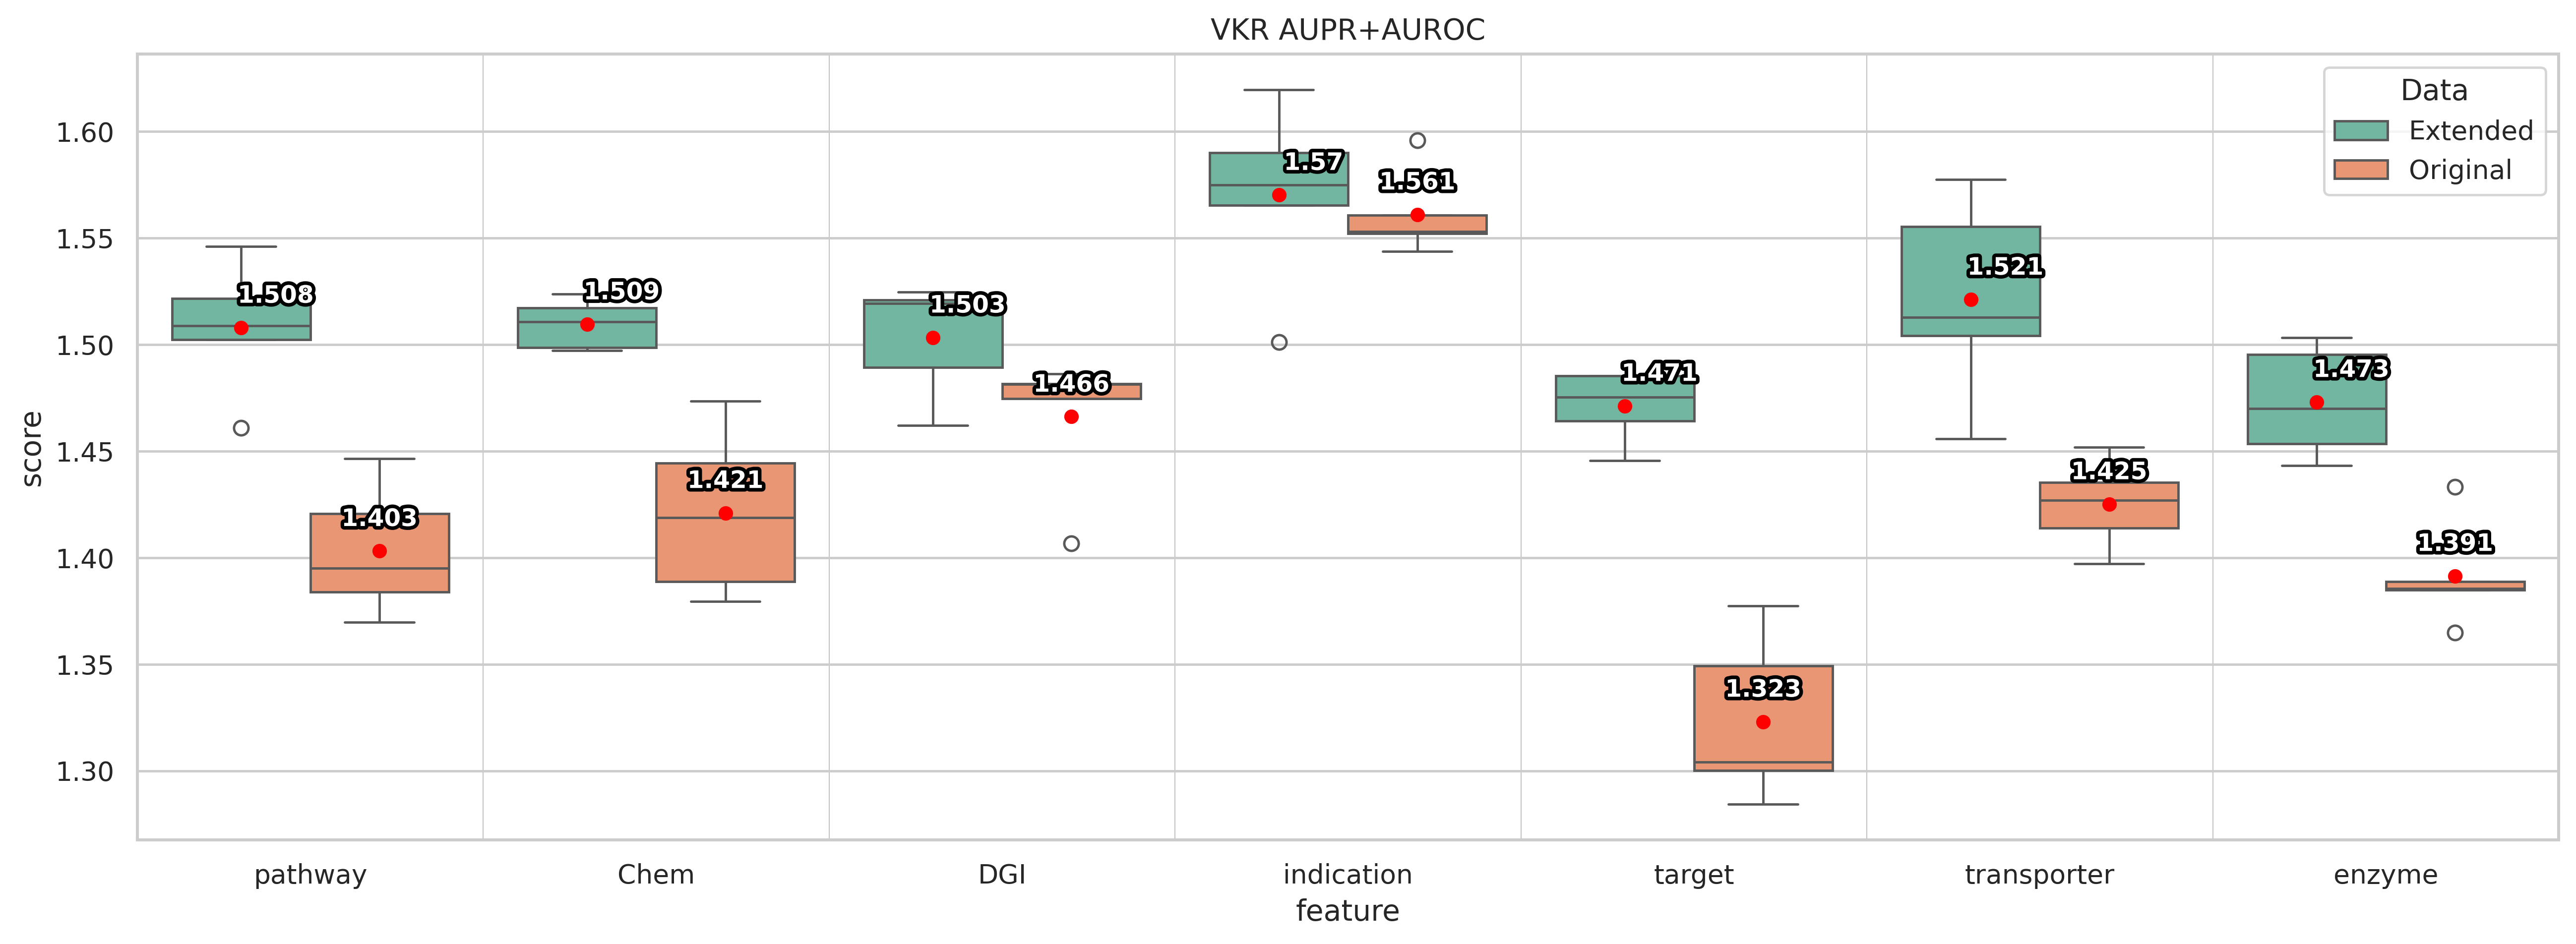

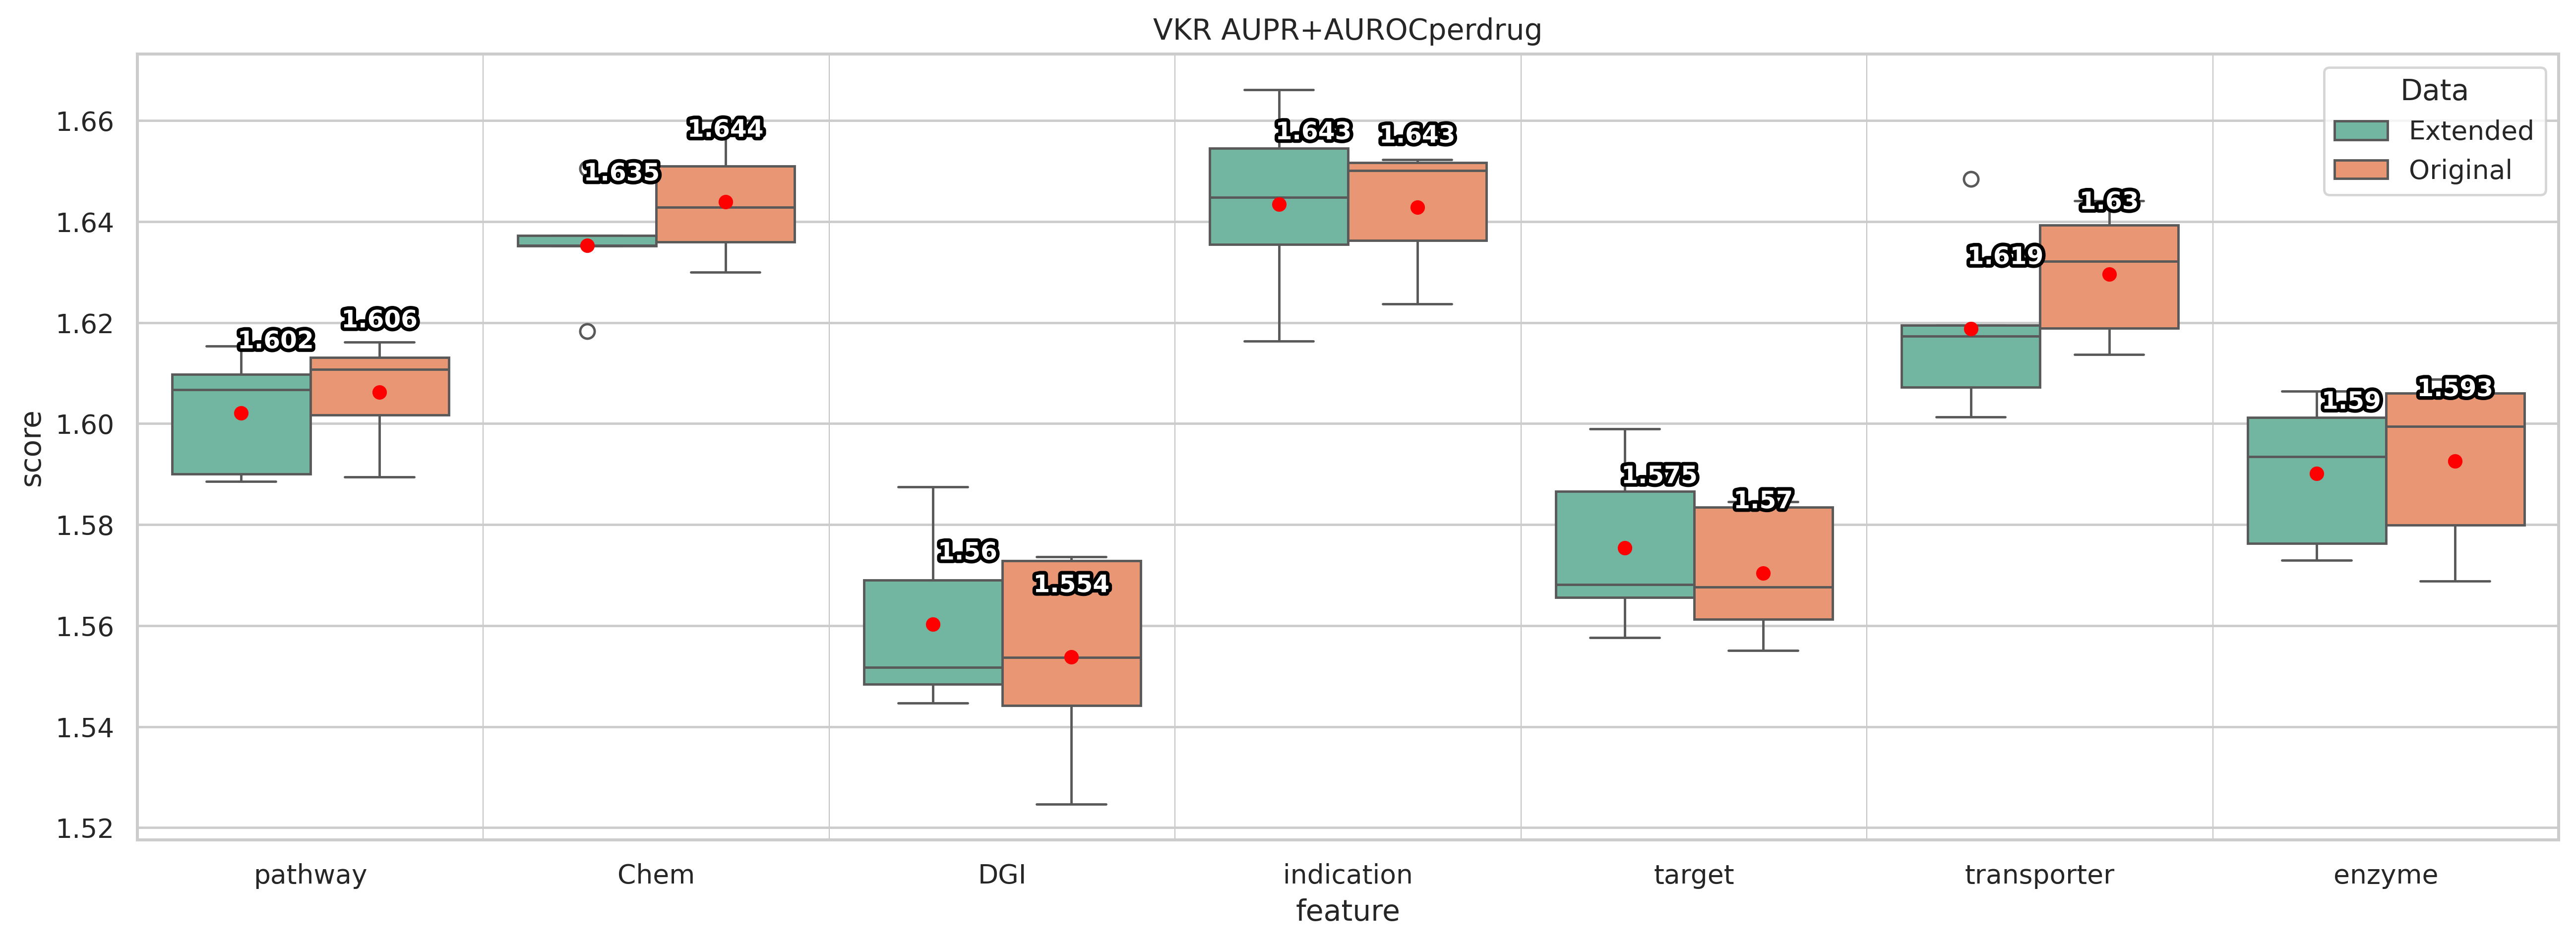

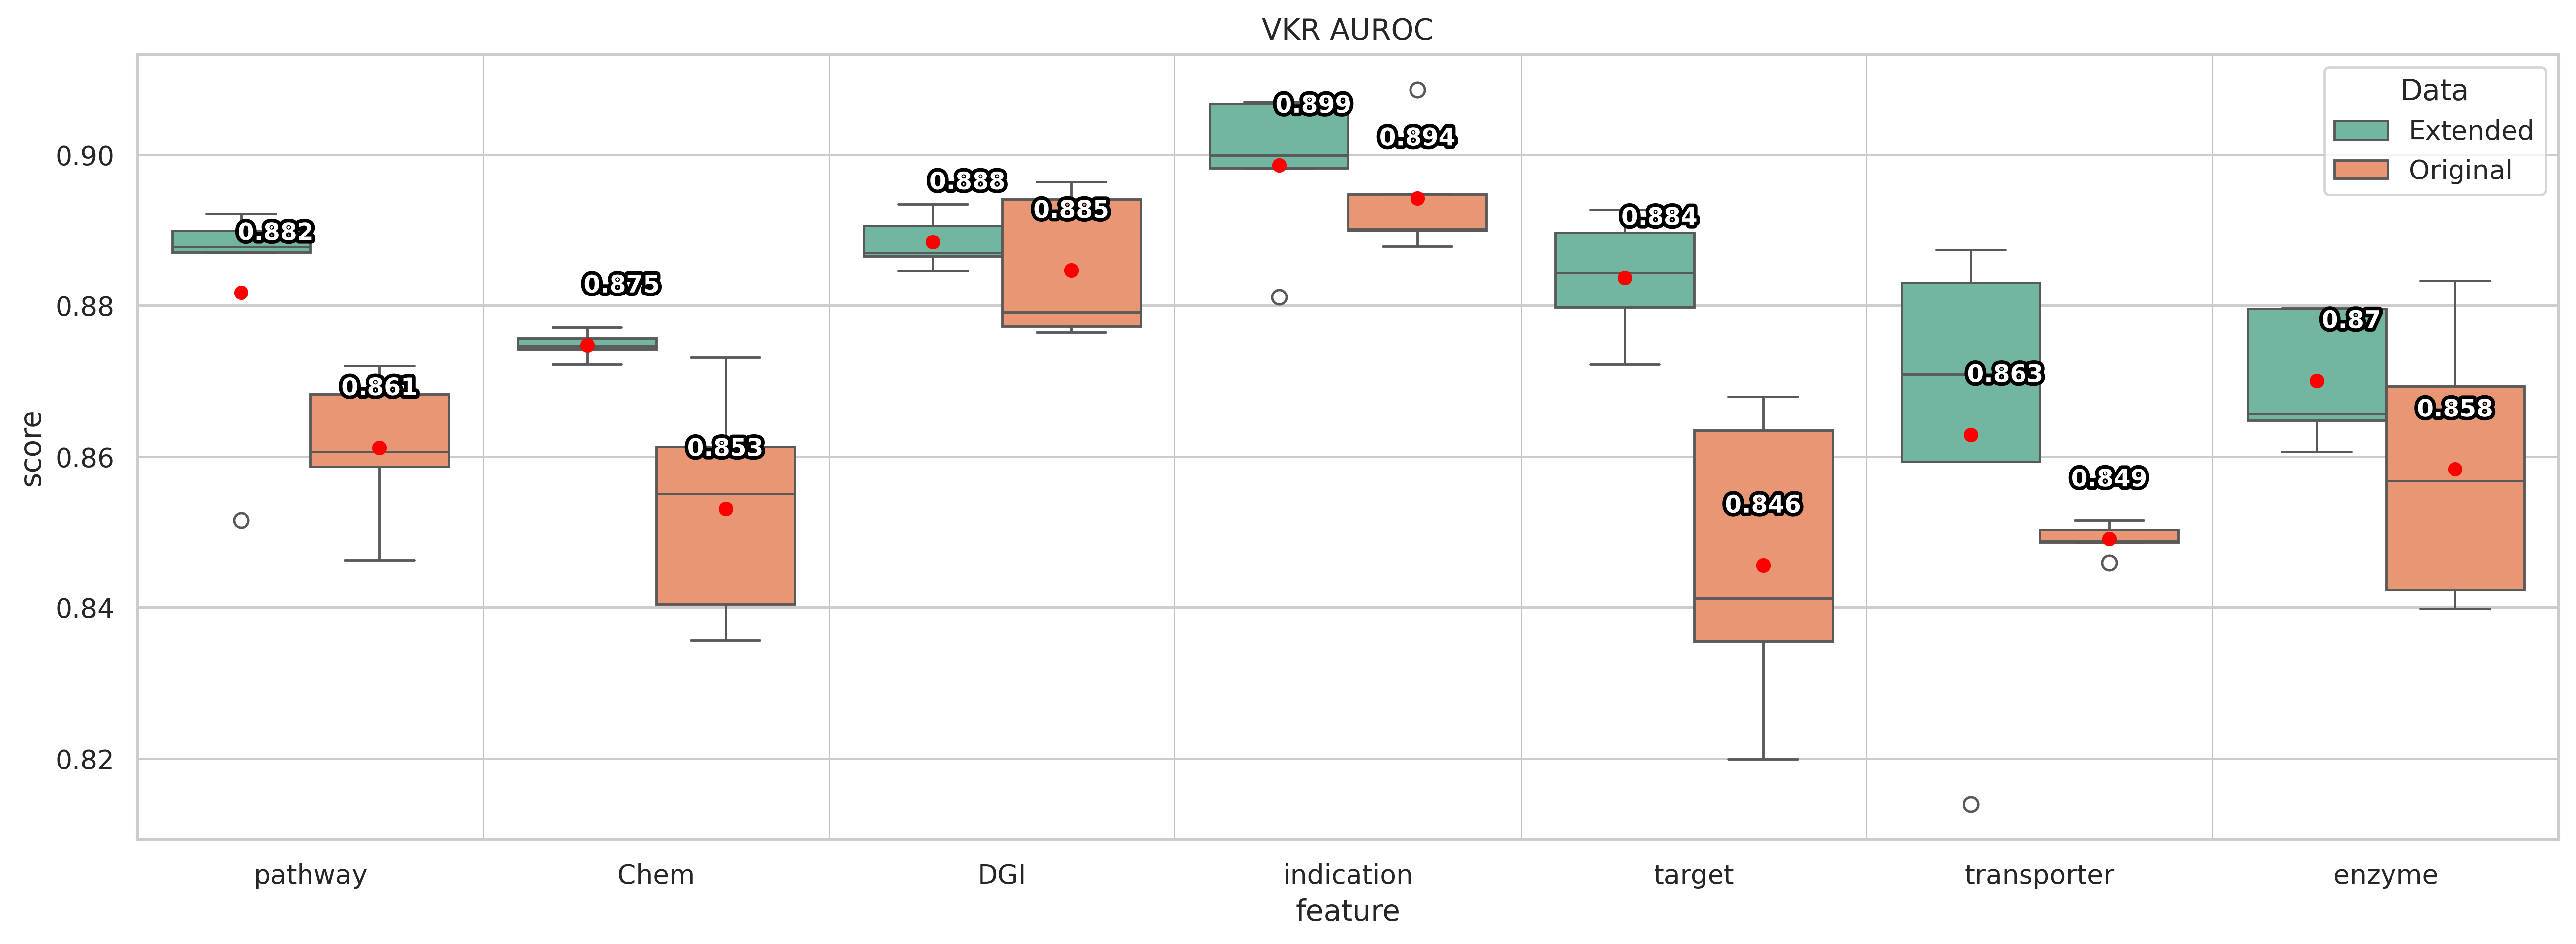

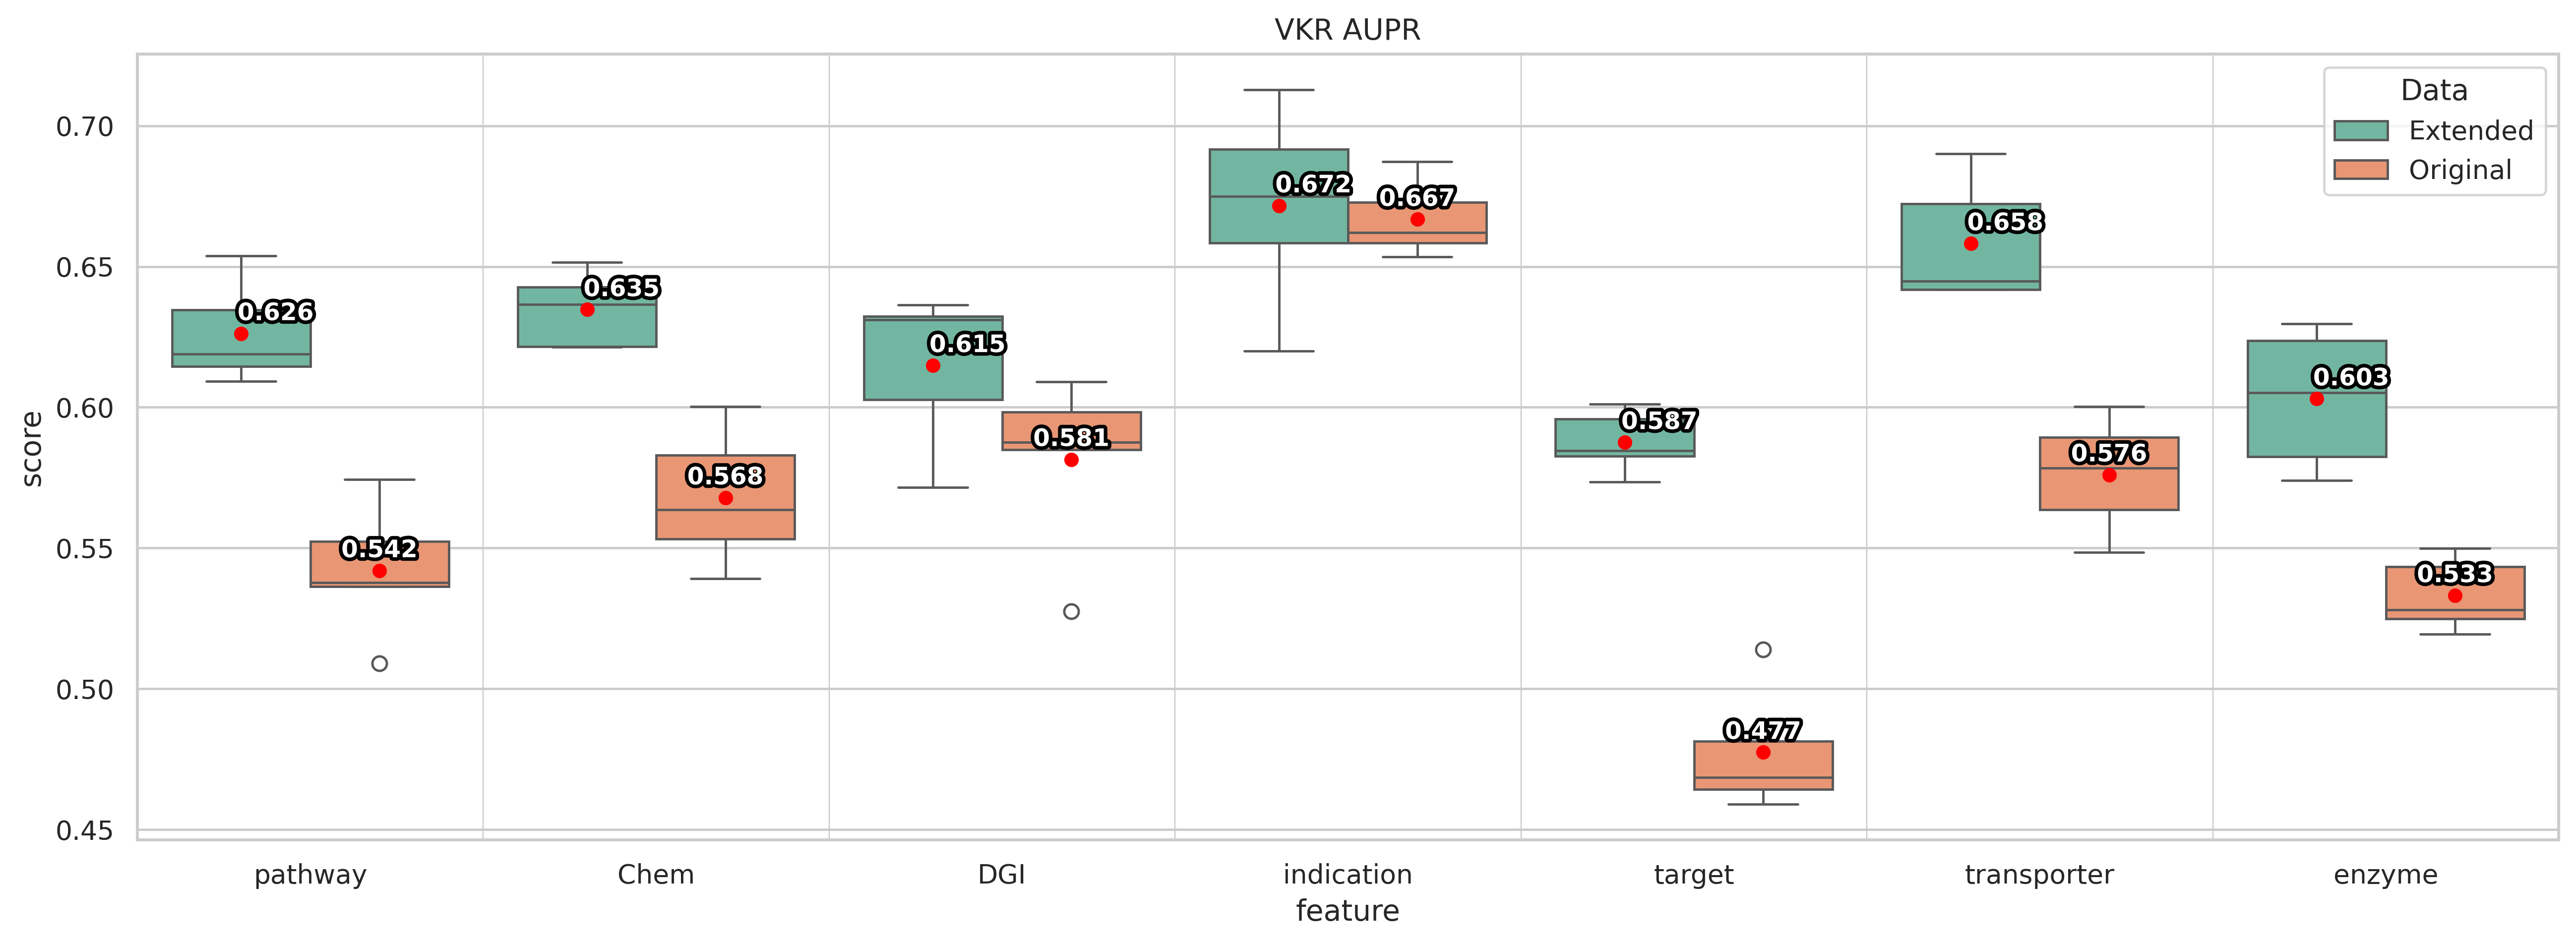

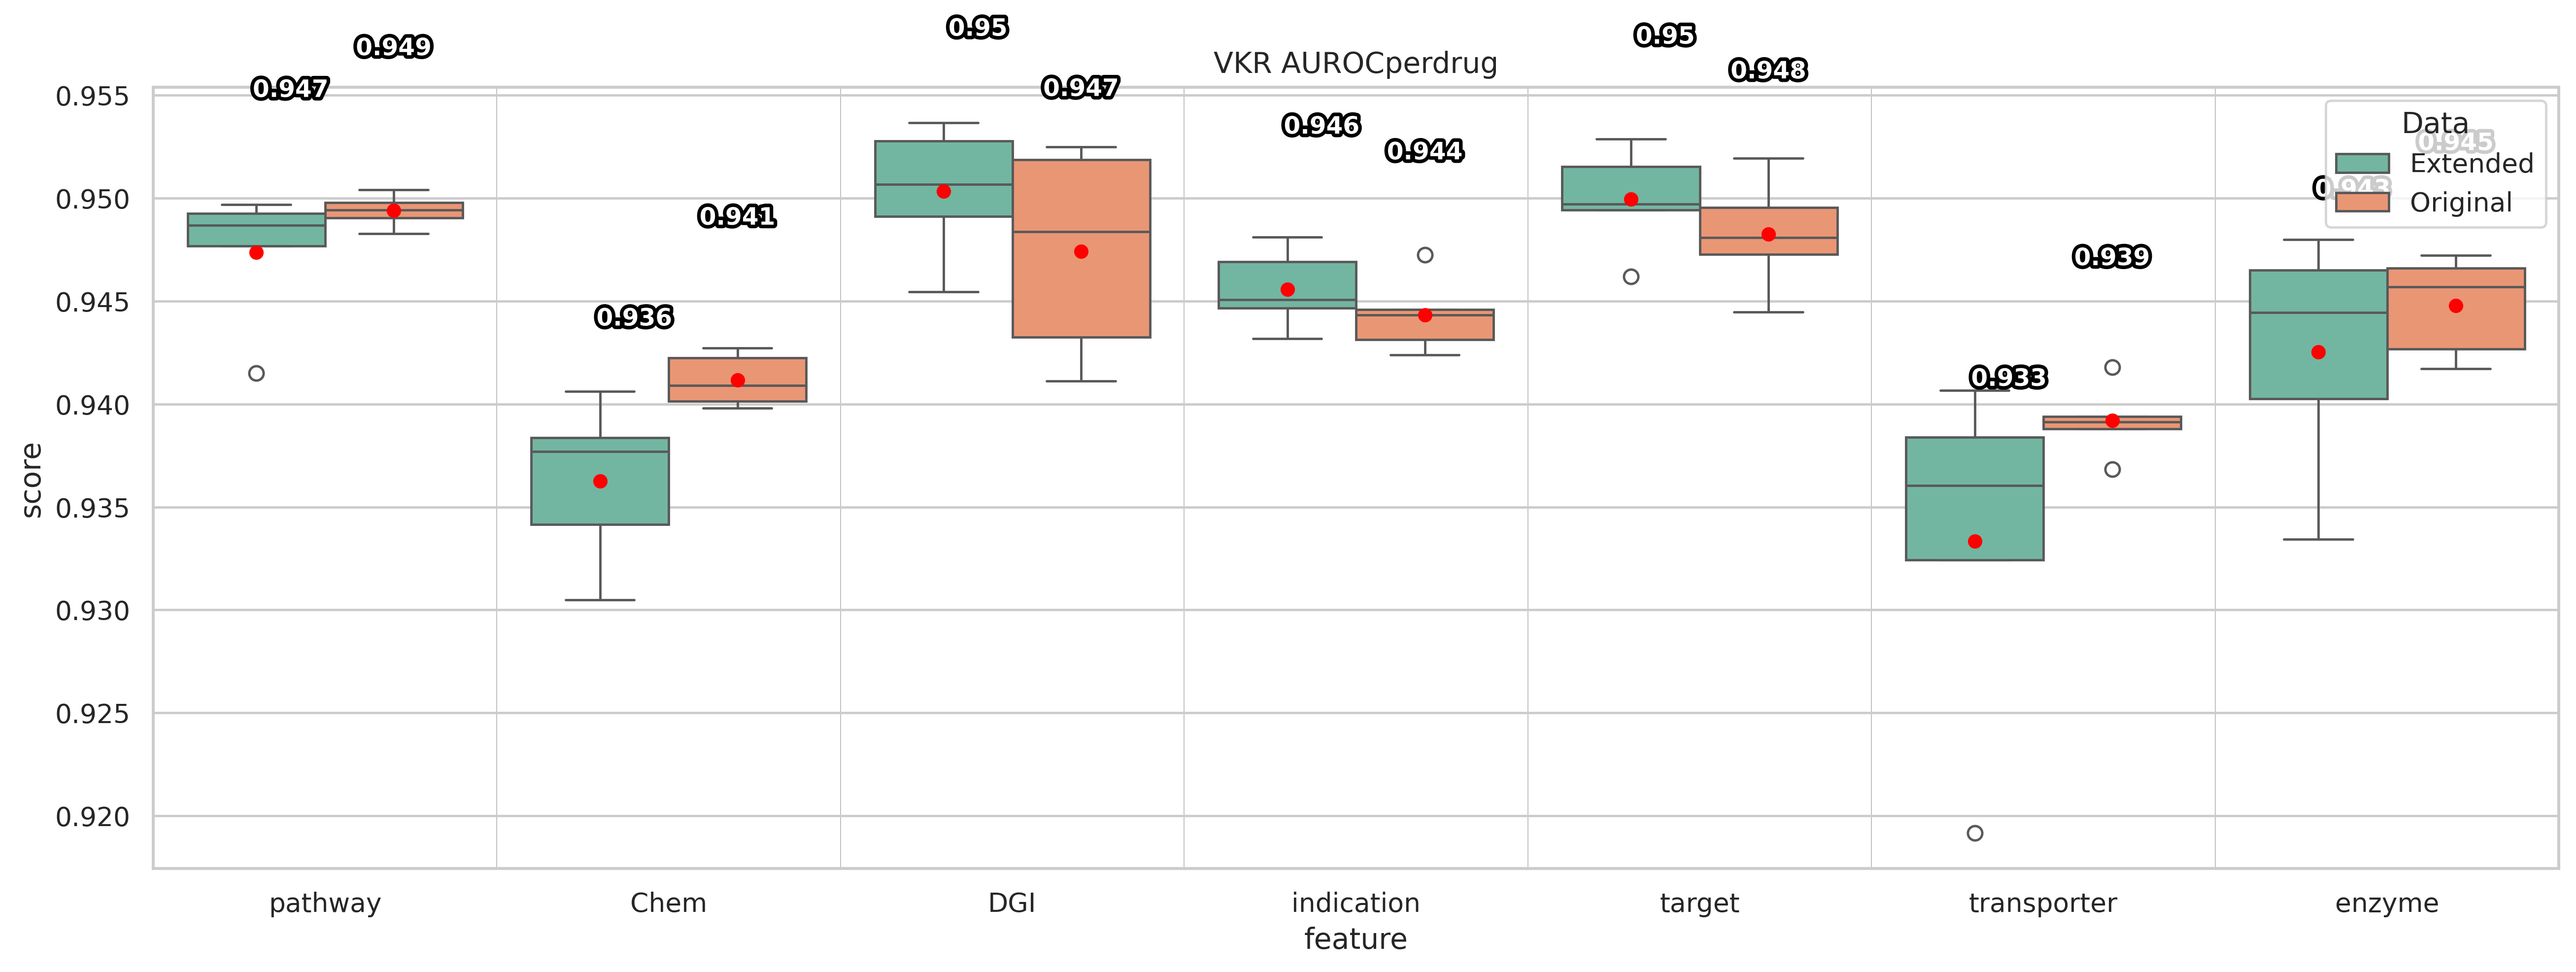

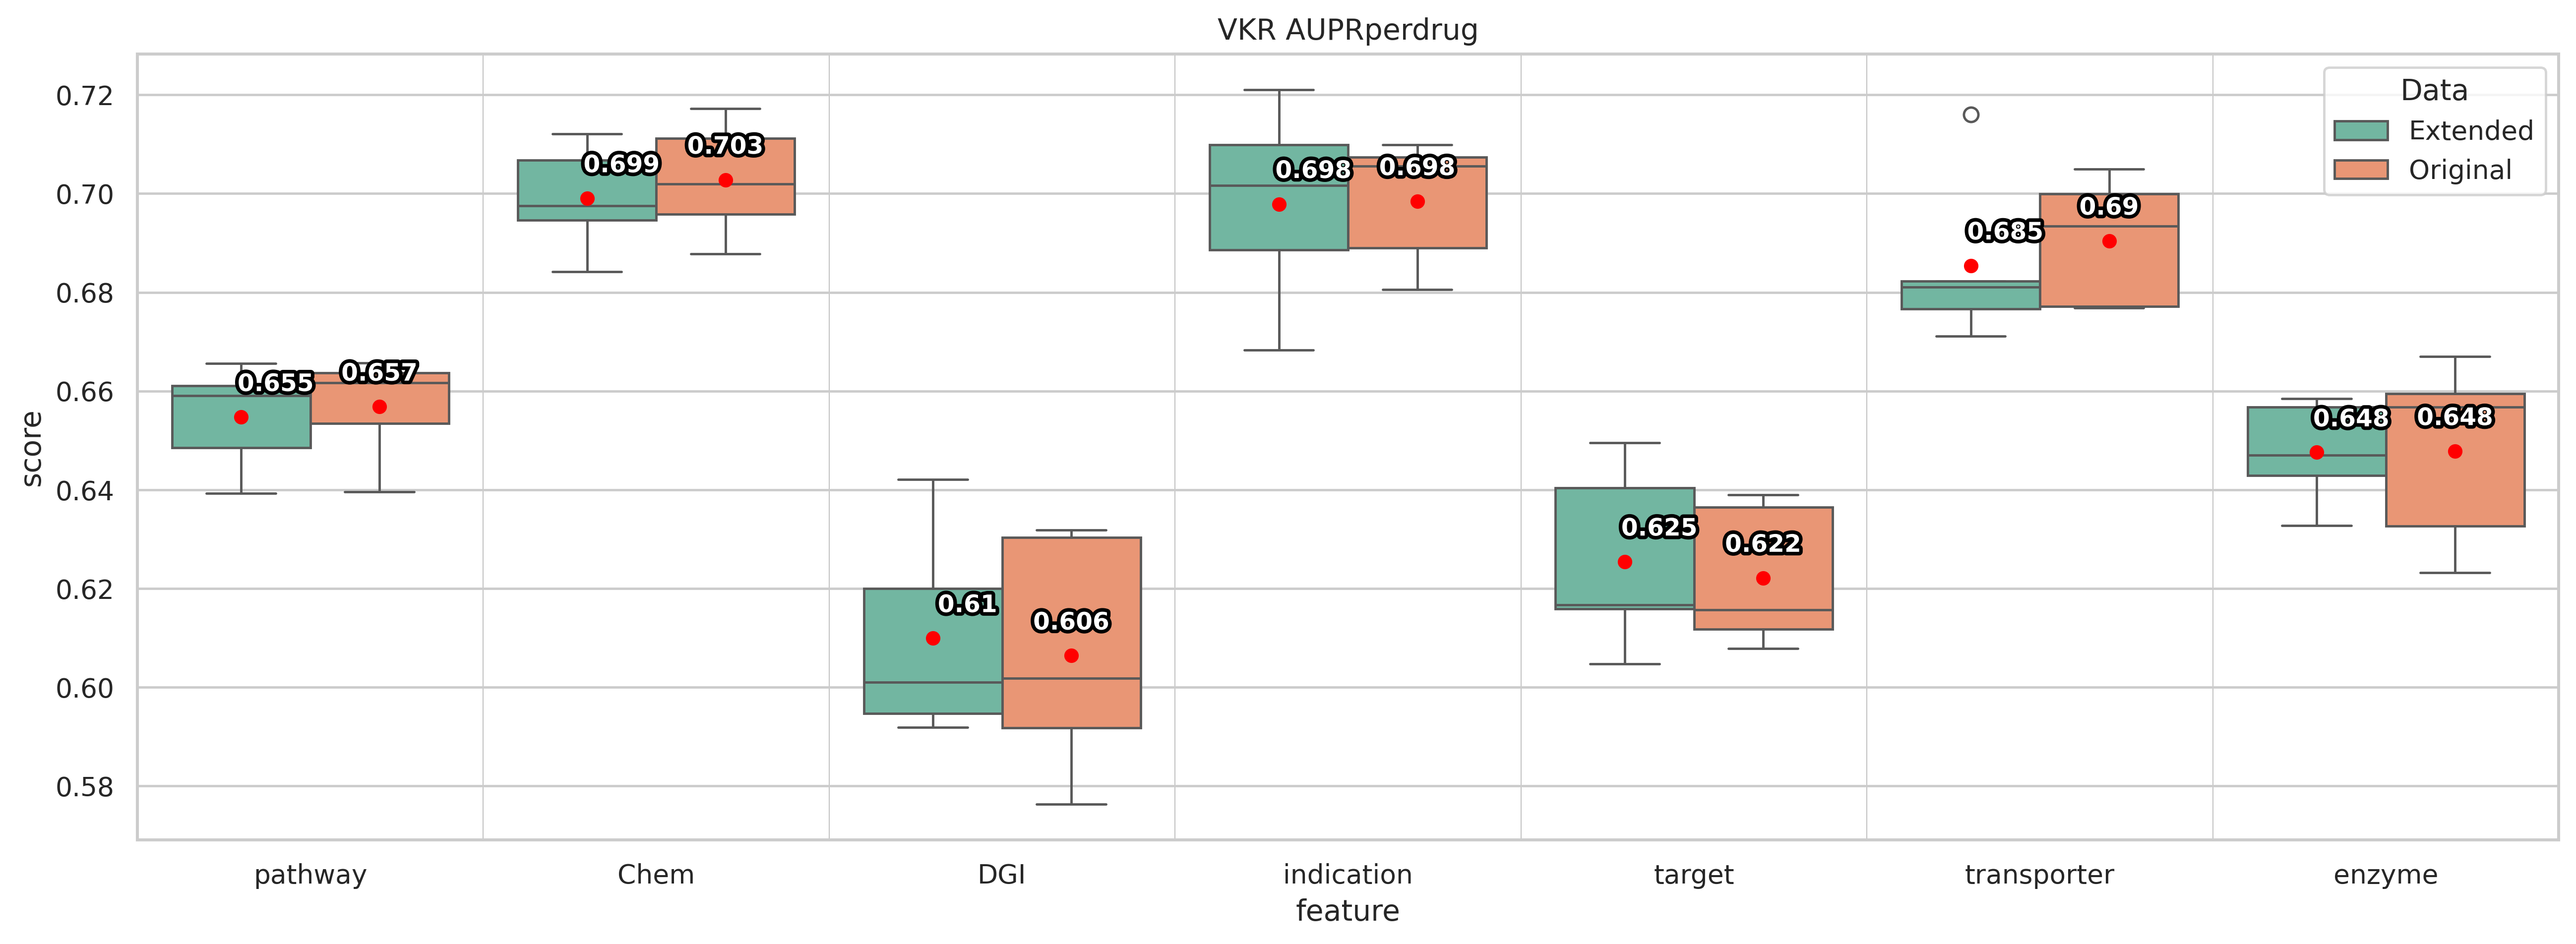

In [106]:
# metrice_names = ["AUROC", "AUPR", "AUPR+AUROC"]
metrice_names = ["AUPR+AUROC", "AUPR+AUROCperdrug", "AUROC", "AUPR", "AUROCperdrug", "AUPRperdrug"]
methods = ["KR", "SKR", "VKR"]
APPFCs = ["Extended", "Original"]
for method in methods:
    df_sorted_method = df_sorted[df_sorted["method"] == method].copy()
    for metrice in metrice_names:
        # sns.set_style('white')
        plt.figure(figsize=(18, 6), dpi=350)
    
        sns.set_theme(rc={'figure.figsize':(18, 6)},style='whitegrid')
        # sns.axes_style("whitegrid")
        dfplot = df_sorted_method[df_sorted_method["metric"]==metrice]
        means = {}
        vertical_offset = dfplot['score'].mean() * 0.008
        ax = sns.boxplot(x = dfplot['feature'], 
                    y = dfplot['score'], 
                    hue = dfplot['Data'], 
                    palette = 'Set2',
                    showmeans=True,
                    meanprops={'marker':'o',
                               'markerfacecolor':'red', 
                               'markeredgecolor':'red',
                               'markersize':'5'}
                               )
        for APPFC in APPFCs:
            means[APPFC] = dfplot[dfplot["Data"]==APPFC].groupby(['feature'])["score"].mean()
        i = -0.4
    
        for APPFC in APPFCs:
            i += 0.3
            for xtick in ax.get_xticks():
                text = ax.text(xtick + i, means[APPFC][xtick] + vertical_offset, round(means[APPFC][xtick], 3), 
                               horizontalalignment='center',size='small',color='white',weight='semibold')
                text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'), path_effects.Normal()])
    
        ax.xaxis.set_minor_locator(MultipleLocator(0.5))
        ax.xaxis.grid(True, which='minor', color='black', lw=0.1)
        plt.title(method + " " + metrice)
        plt.savefig(fname=f"figs/{SEs_name}_{method}_{metrice}.jpg", bbox_inches="tight")
        plt.show()

In [20]:
results

{'nested_cv': {'VKR': {'noAPPFC': {'target': {'AUPRperdrug': [0.6078040251652234,
      0.6364507479655167,
      0.6117600947005191,
      0.6156871342512876,
      0.6390044058689902],
     'AUROCperdrug': [0.947284456208504,
      0.9480954555991262,
      0.9495446115568298,
      0.9519368895822321,
      0.9444829971975331],
     'AUPR+AUROCperdrug': [1.5550884813737273,
      1.584546203564643,
      1.5613047062573489,
      1.5676240238335197,
      1.5834874030665234],
     'AUPR': [0.458911170787034,
      0.5138432763356497,
      0.46854610173489764,
      0.4813737300488777,
      0.46432436021384516],
     'AUROC': [0.841203801420788,
      0.8634510043150715,
      0.8355544672020427,
      0.8679385316597469,
      0.8199245659965034],
     'AUPR+AUROC': [1.300114972207822,
      1.3772942806507213,
      1.3041005689369403,
      1.3493122617086246,
      1.2842489262103487]},
    'enzyme': {'AUPRperdrug': [0.62317728443699,
      0.6594555523138633,
      0.656785776

In [92]:
methods = ["SKR", "KRR", "VKR"]
for method in methods:    
    df = pd.DataFrame()
    for m, fs in results["nested_cv"][method].items():
        for f, mes in fs.items():
            for me, scores in mes.items():
                temp_df = pd.DataFrame({
                    'APPFC': m,
                    'feature': f,
                    'metric': me,
                }, index=["1"])
                temp_df2 = pd.concat([temp_df, pd.DataFrame(scores, columns=["1"]).T], axis=1)
                df = pd.concat([df, temp_df2], ignore_index=True)
    for m in metrice_names:
        for f in features_names:
            df2 = df[(df["metric"] == m) & (df["feature"] == f)]
            df3 = df2.iloc[:, np.array([0, 3, 4, 5, 6, 7])]
            df4 = df3.set_index(df3.columns[0])
            df5 = df4.T.ptests(paired=True, stars=False)
            df5.to_excel(f'results/pvalue_{SEs_name}_{method}_{f}_{m}.xlsx')